In [1]:
# data read & write libraries
import pandas as pd
import numpy as np
import os
import xarray as xr
import netCDF4
from netCDF4 import num2date
import folium

# Regression Models
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV

# Performance metrics & preprocessors
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Geospatial
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import imageio
import pathlib
import mapclassify as mc

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import plotly.express as px
import missingno as msno
sns.set()
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [71]:
df = xr.open_dataset("mediterranean_wavedata.nc")

In [72]:
df

<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 21, longitude: 28, time: 11970)
Coordinates:
  * longitude  (longitude) float32 22.5 23.0 23.5 24.0 ... 34.5 35.0 35.5 36.0
  * latitude   (latitude) float32 41.0 40.5 40.0 39.5 ... 32.5 32.0 31.5 31.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 2010-01-01 ... 2020-12-03T16:00:00
Data variables:
    mdww       (time, expver, latitude, longitude) float32 ...
    mpww       (time, expver, latitude, longitude) float32 ...
    mwp        (time, expver, latitude, longitude) float32 ...
    shww       (time, expver, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-12-08 12:41:58 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [74]:
# confert dataframe to csv format from netcdf4
nc = xr.open_dataset('mediterranean_wavedata.nc')
nc.to_dataframe().to_csv('mediterranean/mediterranean_wave.csv')

In [75]:
df = pd.read_csv("mediterranean/mediterranean_wave.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14076720 entries, 0 to 14076719
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   expver     int64  
 1   latitude   float64
 2   longitude  float64
 3   time       object 
 4   mdww       float64
 5   mpww       float64
 6   mwp        float64
 7   shww       float64
dtypes: float64(6), int64(1), object(1)
memory usage: 859.2+ MB


In [76]:
df.head()

expver  latitude  longitude                 time  mdww  mpww  mwp  shww
0       1      41.0       22.5  2010-01-01 00:00:00   NaN   NaN  NaN   NaN
1       1      41.0       22.5  2010-01-01 08:00:00   NaN   NaN  NaN   NaN
2       1      41.0       22.5  2010-01-01 16:00:00   NaN   NaN  NaN   NaN
3       1      41.0       22.5  2010-01-02 00:00:00   NaN   NaN  NaN   NaN
4       1      41.0       22.5  2010-01-02 08:00:00   NaN   NaN  NaN   NaN

In [77]:
df['power'] = 0.49 * df['mpww'] * (df['shww'] ** 2)

<AxesSubplot:>

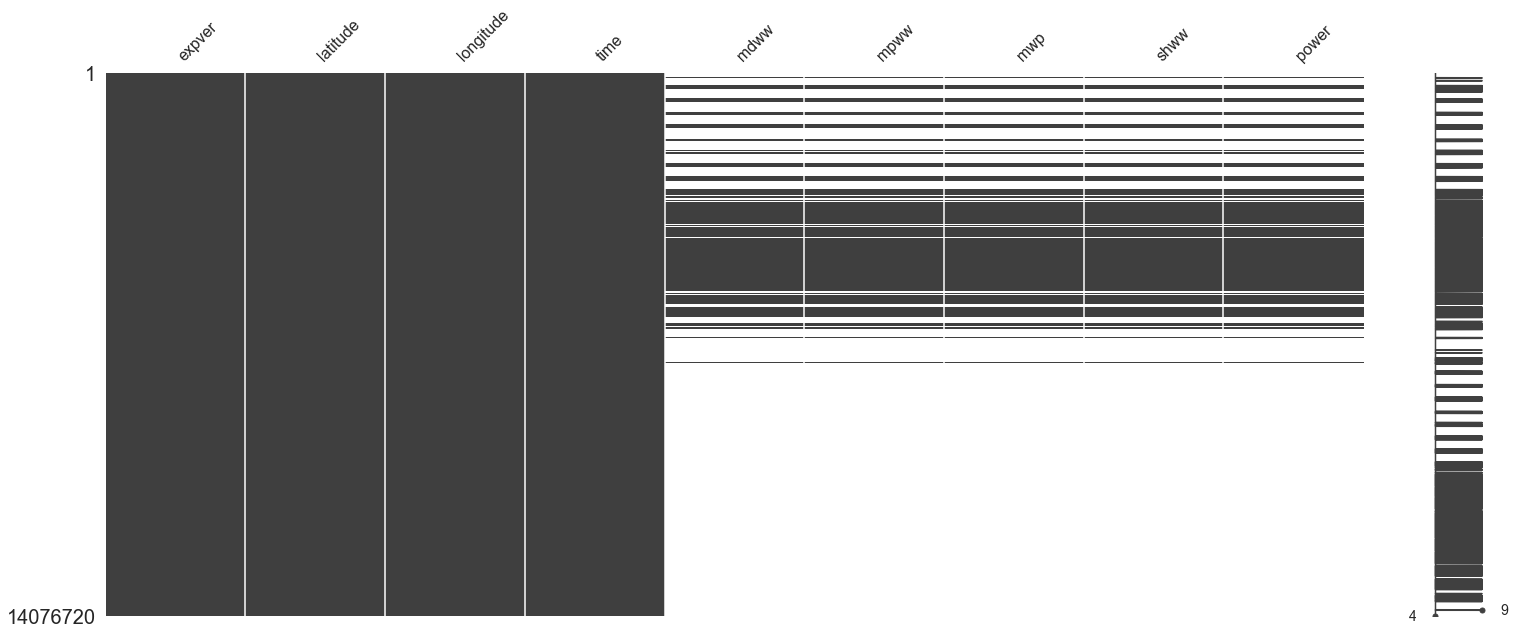

In [78]:
msno.matrix(df)
# white indicates missing data

In [79]:
df.isnull().sum()

expver              0
latitude            0
longitude           0
time                0
mdww         10114650
mpww         10114650
mwp          10114650
shww         10114650
power        10114650
dtype: int64

### Forming time-series indexed dataset

In [80]:
# dropping columns with the missing values
era_c = df.copy()

In [81]:
# adjusting time columns
era_c["time"] = pd.to_datetime(era_c["time"])
era_c["time"].head()

0   2010-01-01 00:00:00
1   2010-01-01 08:00:00
2   2010-01-01 16:00:00
3   2010-01-02 00:00:00
4   2010-01-02 08:00:00
Name: time, dtype: datetime64[ns]

In [82]:
# creating new dataset with fixed time parameter
era_c.to_csv('mediterranean/mediterranean_date.csv')

In [2]:
era_t = pd.read_csv('mediterranean/mediterranean_date.csv', index_col="time", parse_dates=True)
era_t.drop('Unnamed: 0', axis=1, inplace=True)

In [84]:
# shape of the dataframe
era_t.shape

(14076720, 8)

In [28]:
# era_t.dropna(how='any', axis=0, inplace=True)

# Time-Series Analysis

## 1. Analysis of Mediterraneans' Potential 

In [86]:
# era_t['wind_speed'] = ((era_t['u10'] ** 2) + (era_t['v10'] ** 2)) ** 0.5

In [4]:
# Reorder columns
'''
era_t=era_t[['u10', 'v10', 'wind_speed', 'mpww', 'shww', 
             'power', 'latitude', 'longitude']]
era_t.info()
'''

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22608630 entries, 2010-01-01 00:00:00 to 2019-11-30 16:00:00
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   u10         float64
 1   v10         float64
 2   wind_speed  float64
 3   mpww        float64
 4   shww        float64
 5   power       float64
 6   latitude    float64
 7   longitude   float64
dtypes: float64(8)
memory usage: 1.5 GB


In [3]:
era = gpd.GeoDataFrame(era_t, geometry = gpd.points_from_xy(
                        era_t.longitude, era_t.latitude))

In [88]:
era.head()

expver  latitude  longitude  mdww  mpww  mwp  shww  \
time                                                                      
2010-01-01 00:00:00       1      41.0       22.5   NaN   NaN  NaN   NaN   
2010-01-01 08:00:00       1      41.0       22.5   NaN   NaN  NaN   NaN   
2010-01-01 16:00:00       1      41.0       22.5   NaN   NaN  NaN   NaN   
2010-01-02 00:00:00       1      41.0       22.5   NaN   NaN  NaN   NaN   
2010-01-02 08:00:00       1      41.0       22.5   NaN   NaN  NaN   NaN   

                     power                   geometry  
time                                                   
2010-01-01 00:00:00    NaN  POINT (22.50000 41.00000)  
2010-01-01 08:00:00    NaN  POINT (22.50000 41.00000)  
2010-01-01 16:00:00    NaN  POINT (22.50000 41.00000)  
2010-01-02 00:00:00    NaN  POINT (22.50000 41.00000)  
2010-01-02 08:00:00    NaN  POINT (22.50000 41.00000)

In [114]:
era['expver'].value_counts()

1    3898518
5      63552
Name: expver, dtype: int64

In [7]:
era.dropna(how='any', axis=0, inplace=True)
era.isnull().sum()

expver       0
latitude     0
longitude    0
mdww         0
mpww         0
mwp          0
shww         0
power        0
geometry     0
dtype: int64

<AxesSubplot:>

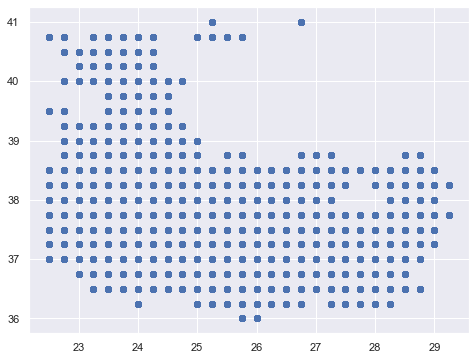

In [9]:
fig, ax = plt.subplots(1, figsize=(10, 6))
era.plot(ax=ax)

Text(0.5, 1.0, 'Mean Period Levels of Wind Waves')

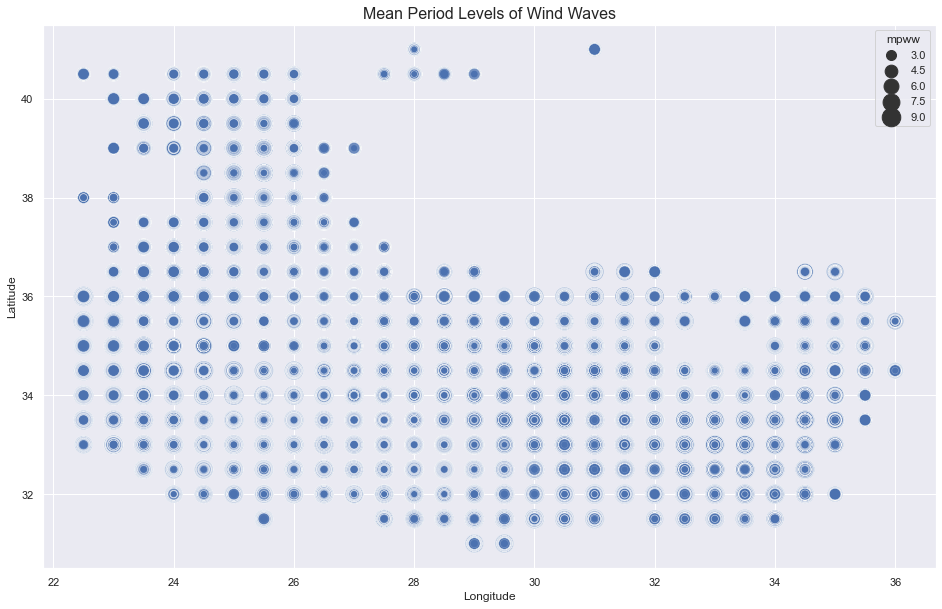

In [5]:
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x='longitude', y='latitude',
                     size='mpww',
                     sizes=(40, 400), alpha=.7,
                     data=era)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Mean Period Levels of Wind Waves', fontsize=16)

Text(0.5, 1.0, 'Mean Height Levels of Wind Waves')

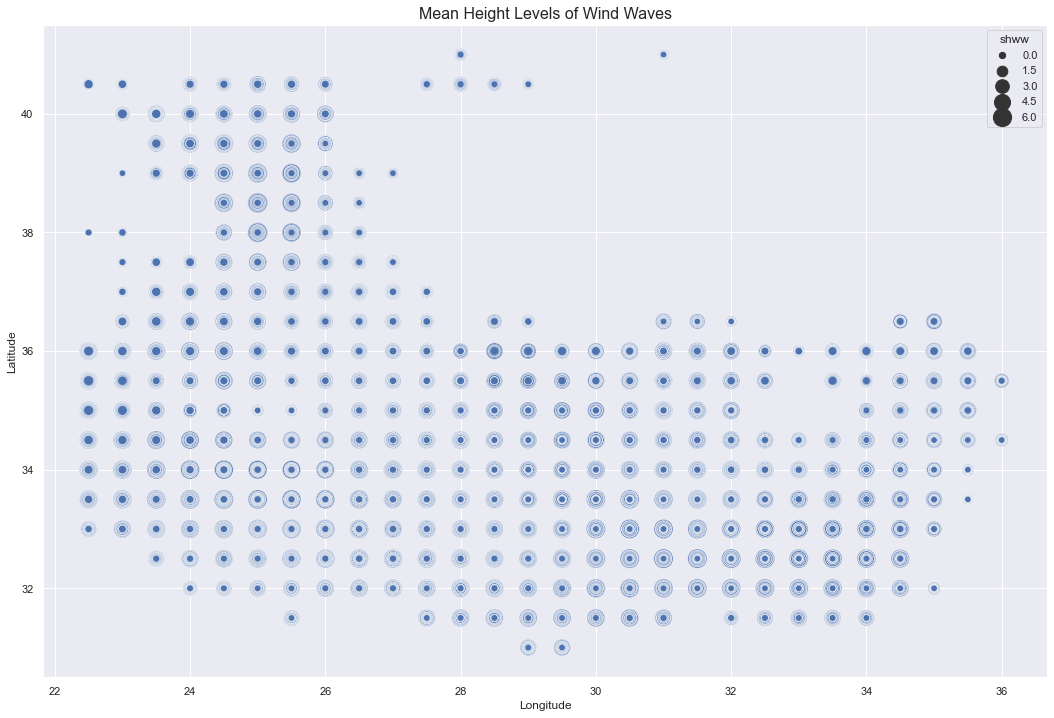

In [6]:
plt.figure(figsize=(18, 12))
ax = sns.scatterplot(x='longitude', y='latitude',
                     size='shww',
                     sizes=(40, 400), alpha=.7,
                     data=era)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Mean Height Levels of Wind Waves', fontsize=16)

Text(0.5, 1.0, 'General Wave Power Levels [kW/m]')

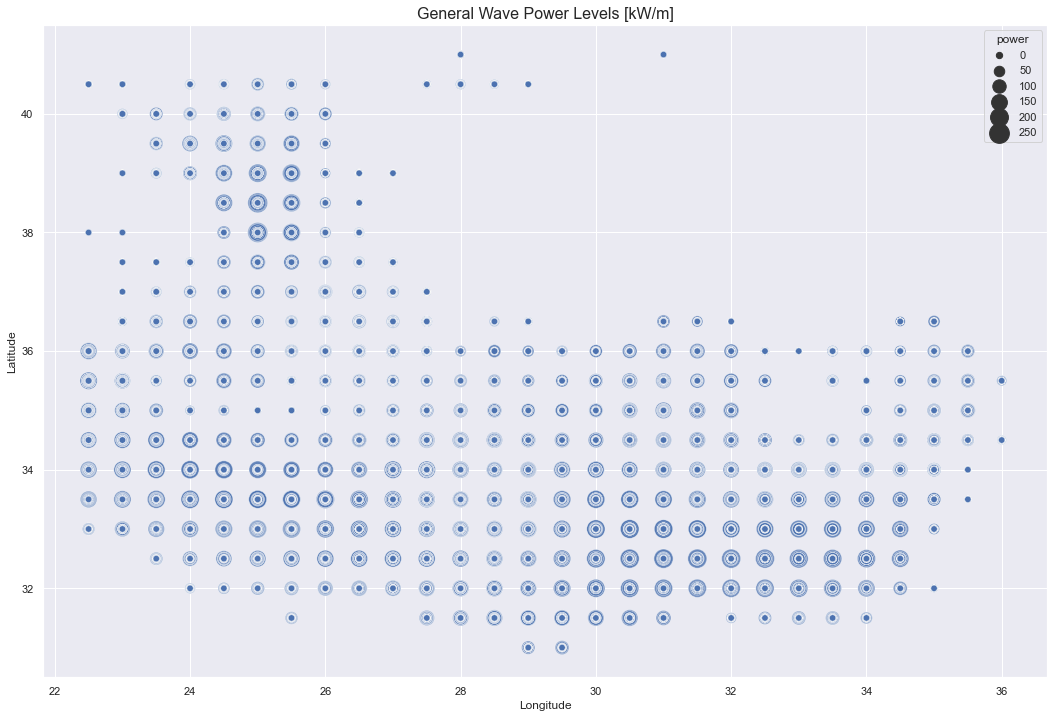

In [7]:
plt.figure(figsize=(18, 12))
ax = sns.scatterplot(x='longitude', y='latitude',
                     size='power',
                     sizes=(40, 400), alpha=.7,
                     data=era)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('General Wave Power Levels [kW/m]', fontsize=16)

Text(0.5, 1.0, 'General Power Levels for Mediterranean between 2010-2020')

<Figure size 1440x1008 with 0 Axes>

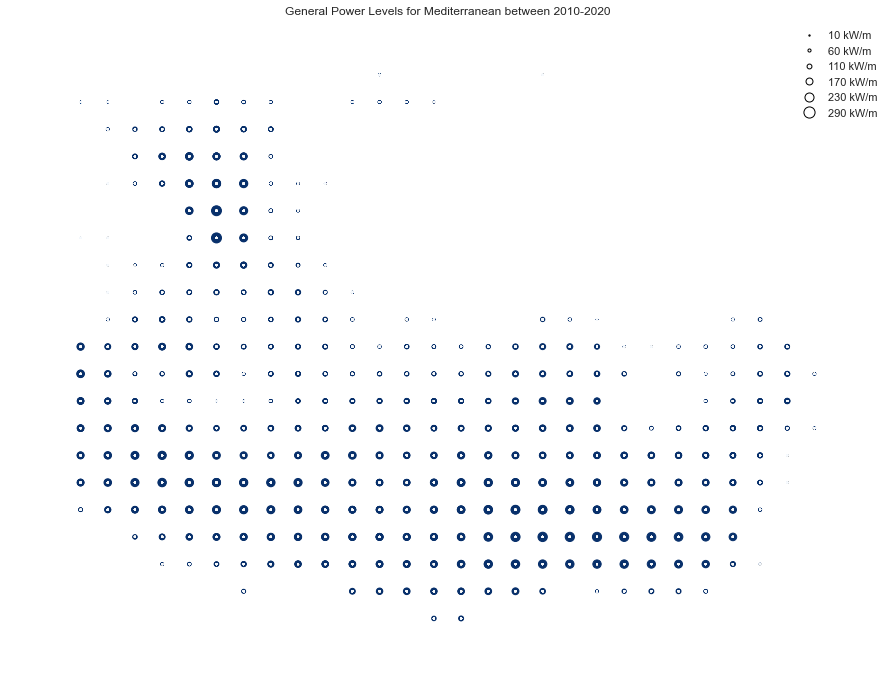

In [8]:
plt.figure(figsize=(20, 14))
ax = gplt.pointplot(
  era,
  hue="power",
  cmap="Blues",
  scheme="quantiles",
  scale="power",
  limits=(1, 10),
  figsize=(18, 12),
  legend=True,
  legend_var="scale",
  legend_kwargs={"frameon": False},
  legend_values=[10, 60, 110, 170, 230, 290],
  legend_labels=['10 kW/m', '60 kW/m', '110 kW/m', '170 kW/m', '230 kW/m', '290 kW/m']
)

ax.set_title("General Power Flux for Mediterranean between 2010-2020", fontsize=12)

Text(0, 0.5, 'Latitude')

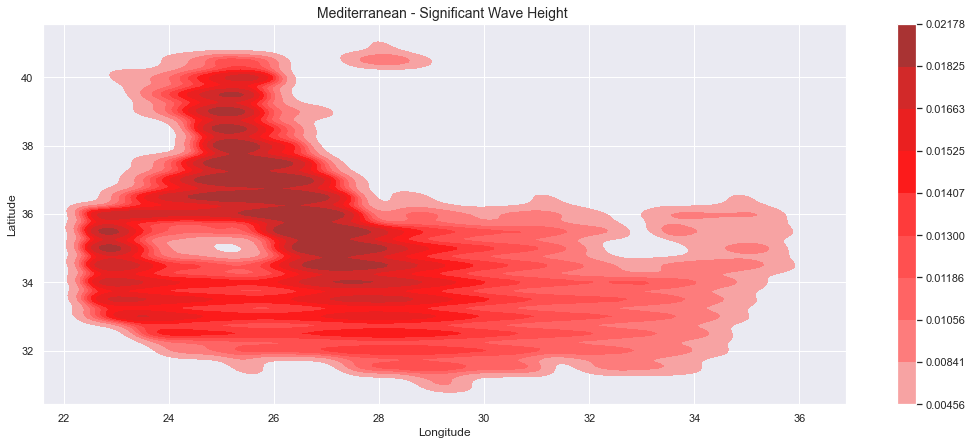

In [18]:
plt.figure(figsize=(18, 7))
ax = sns.kdeplot(data=era, shade=True,
        x='longitude', y='latitude', color='red',
        fill=True, weights='shww', cbar=True, legend=True)

ax.set_title('Mediterranean - Significant Wave Height ', fontsize=14)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

Text(0, 0.5, 'Latitude')

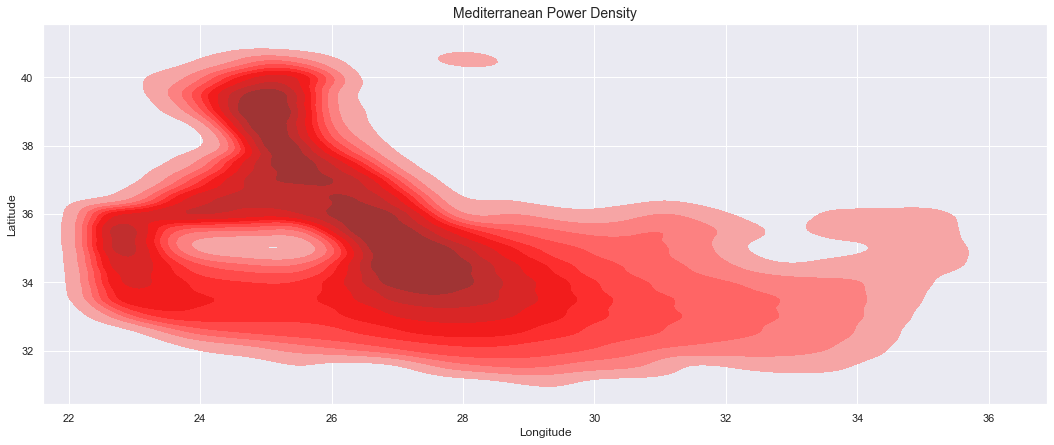

In [17]:
plt.figure(figsize=(18, 7))
ax = sns.kdeplot(data=era, #shade=True,
        x='longitude', y='latitude', color='red',legend=True,
        fill=True, weights='power', #cbar=True
                )

ax.set_title('Mediterranean Power Density', fontsize=14)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

<AxesSubplot:xlabel='time'>

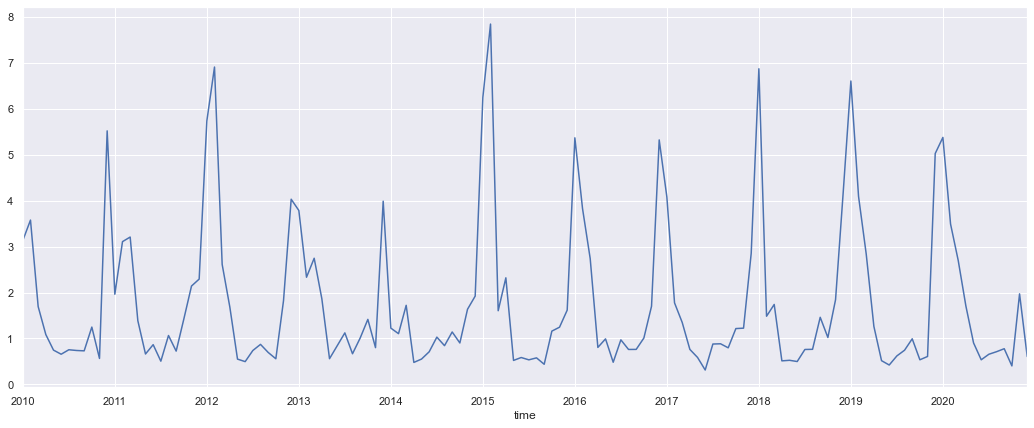

In [71]:
era.power.resample('M').mean().plot(figsize=(18,7))

plt.title('Mean Power Flux Distribution of Mediterranean sea', fontsize=14)
plt.ylabel('Power Flux [kW/m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

<Figure size 1296x504 with 0 Axes>

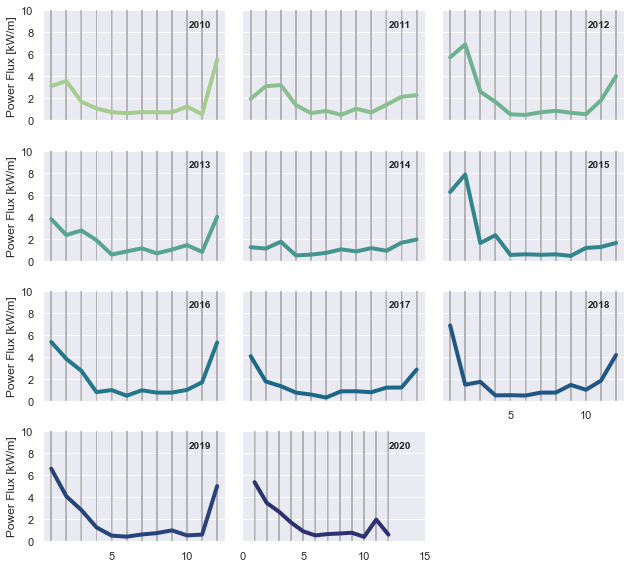

In [6]:
df_c = era_t.copy()
df_c['month'] = pd.DatetimeIndex(df_c.index).month
df_c['year'] = pd.DatetimeIndex(df_c.index).year

plt.figure(figsize=(18, 7))
g = sns.relplot(
    data=df_c,
    x='month', y="power", col="year", 
    hue="year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)
g.set(ylim=(0, 10))

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=df_c, x="month", y="power", units="year",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Power Flux [kW/m]")
g.tight_layout()

### Viz. with Folium 

In [8]:
def generateBaseMap(default_location=[35, 30], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [9]:
from folium.plugins import HeatMap

base_map = generateBaseMap()
HeatMap(data=era[['latitude', 'longitude', 'power']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
folium.LatLngPopup().add_to(base_map)

In [10]:
base_map

## 2. Analysis for a single point - Çanakkale/Gökçeada

In [11]:
cnk = era.loc[((era['latitude'] >= 40.00) & (era['latitude'] <= 40.10) &  (era['longitude'] >= 26.00) & 
                   (era['longitude'] <= 26.10) )]

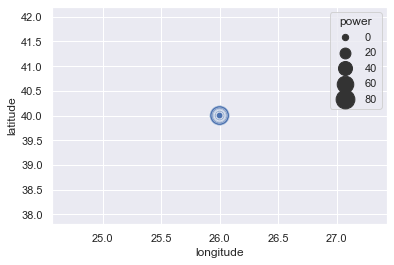

In [8]:
ax = sns.scatterplot(x='longitude', y='latitude',
                     size='power',
                     sizes=(40, 400), alpha=.7,
                     data=cnk)

### Decomposition 

In [107]:
'''
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(cnk['power'], model='Additive')
fig = decomposition.plot()
plt.show()
'''

"\nimport statsmodels.api as sm\ndecomposition = sm.tsa.seasonal_decompose(cnk['power'], model='Additive')\nfig = decomposition.plot()\nplt.show()\n"

### 2.1. Wave Height-Period Distribution in Çanakkale/Gökçeada 

Text(0, 0.5, 'Significant height of wind waves [m]')

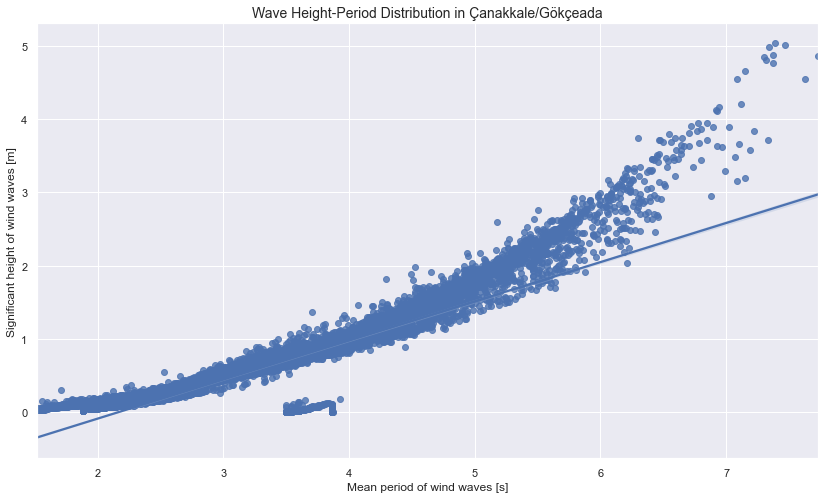

In [32]:
plt.figure(figsize=(14, 8))
g = sns.regplot(
    data=cnk,
    x='mpww', y='shww')
g.set_title('Wave Height-Period Distribution in Çanakkale/Gökçeada', fontsize=14)
g.set_xlabel('Mean period of wind waves [s]', fontsize=12)
g.set_ylabel('Significant height of wind waves [m]', fontsize=12)

### 2.2. Power Flux Graphs

#### 2.2.1. Heatmap Demostration

In [121]:
cnk1 = era_t.loc[((era_t['latitude'] >= 40.00) & (era_t['latitude'] <= 40.10) &  (era_t['longitude'] >= 26.00) & 
                   (era_t['longitude'] <= 26.10) )]

cnk1['month'] = pd.DatetimeIndex(cnk1.index).month
cnk1['year'] = pd.DatetimeIndex(cnk1.index).year

In [124]:
import calendar
all_month_year_df = pd.pivot_table(cnk1, values="power",
                                   index='month',
                                   columns='year',
                                   fill_value=0,
                                   margins=True)
named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_df.index)]] # name months
all_month_year_df = all_month_year_df.set_index(named_index)

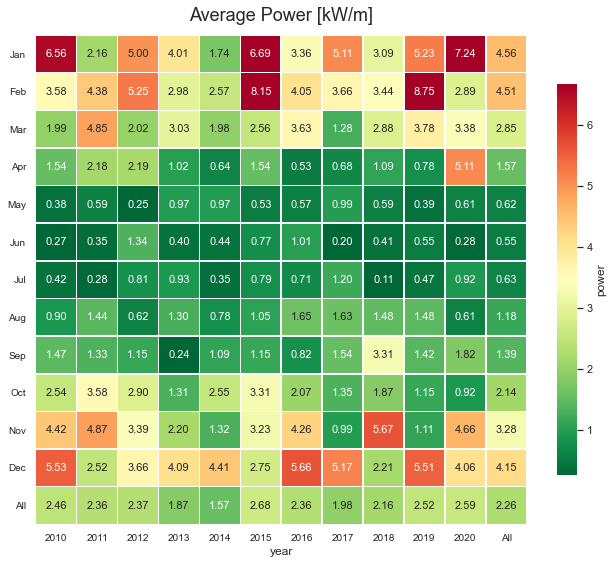

In [125]:
plt.figure(figsize=(15, 11))
ax = sns.heatmap(all_month_year_df, cmap='RdYlGn_r', robust=True, fmt='.2f', 
                 annot=True, linewidths=.5, annot_kws={'size':11}, 
                 cbar_kws={'shrink':.8, 'label':'power'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Çanakkale - Average Power [kW/m]', fontdict={'fontsize':16},    pad=14);

#### 2.2.2. Power Distribution Graphs 

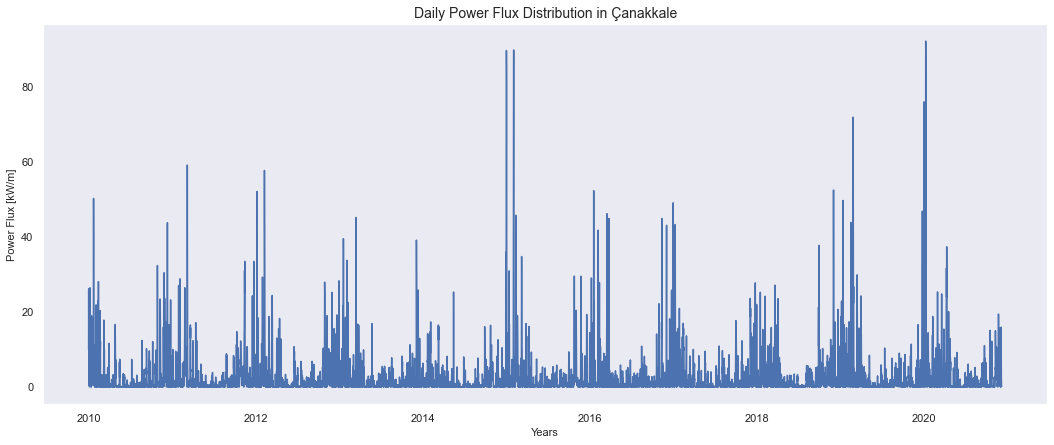

In [12]:
plt.figure(figsize=(18, 7))
plt.plot(cnk.power)

plt.title('Daily Power Flux Distribution in Çanakkale', fontsize=14)
plt.ylabel('Power Flux [kW/m]', fontsize=11)
plt.xlabel('Years', fontsize=11)
plt.grid(False)
plt.show()

Text(0.5, 0, 'Years')

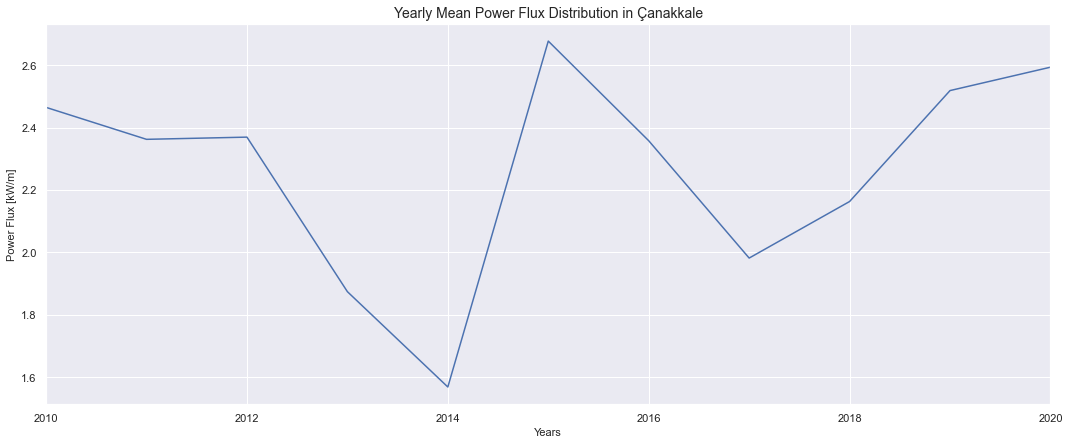

In [13]:
cnk.power.resample('Y').mean().plot(figsize=(18,7))
plt.title('Yearly Mean Power Flux Distribution in Çanakkale', fontsize=14)
plt.ylabel('Power Flux [kW/m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

Text(0.5, 0, 'Years')

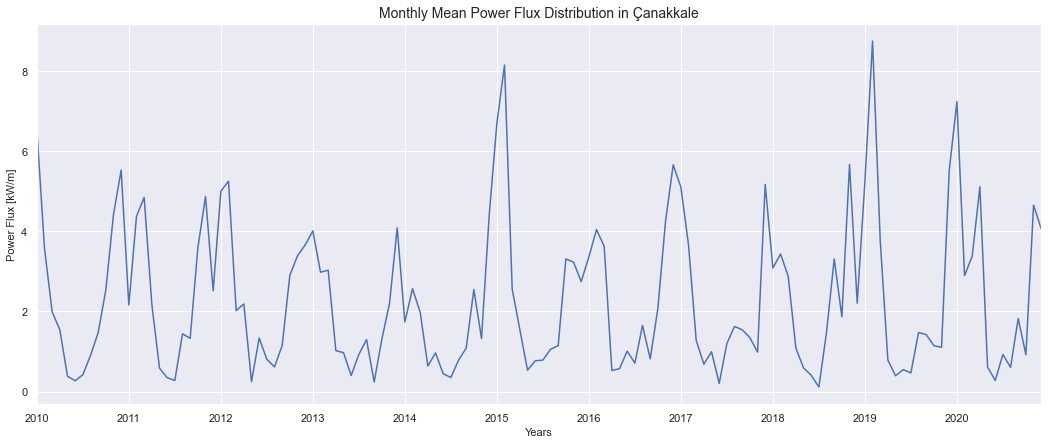

In [14]:
cnk.power.resample('M').mean().plot(figsize=(18,7))
plt.title('Monthly Mean Power Flux Distribution in Çanakkale', fontsize=14)
plt.ylabel('Power Flux [kW/m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

Text(0.5, 0, 'Years')

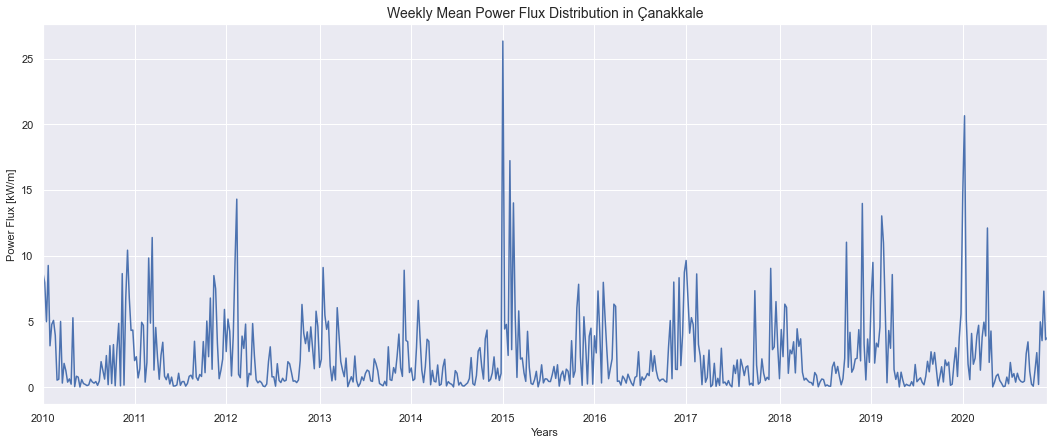

In [15]:
cnk.power.resample('W').mean().plot(figsize=(18,7))
plt.title('Weekly Mean Power Flux Distribution in Çanakkale', fontsize=14)
plt.ylabel('Power Flux [kW/m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

### 2.3. Viz. for significant height of wind waves 

Text(0.5, 0, 'Years')

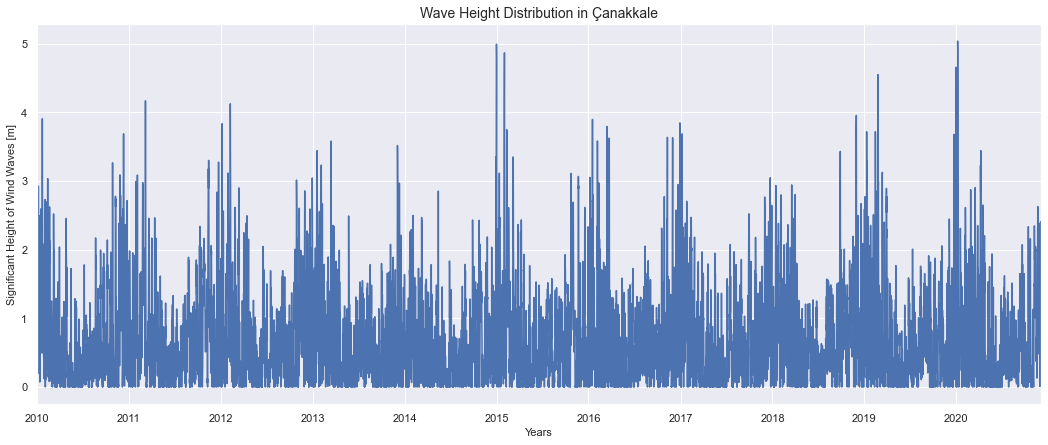

In [16]:
cnk.shww.plot(figsize=(18,7))
plt.title('Wave Height Distribution in Çanakkale', fontsize=14)
plt.ylabel('Significant Height of Wind Waves [m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

Text(0.5, 0, 'Years')

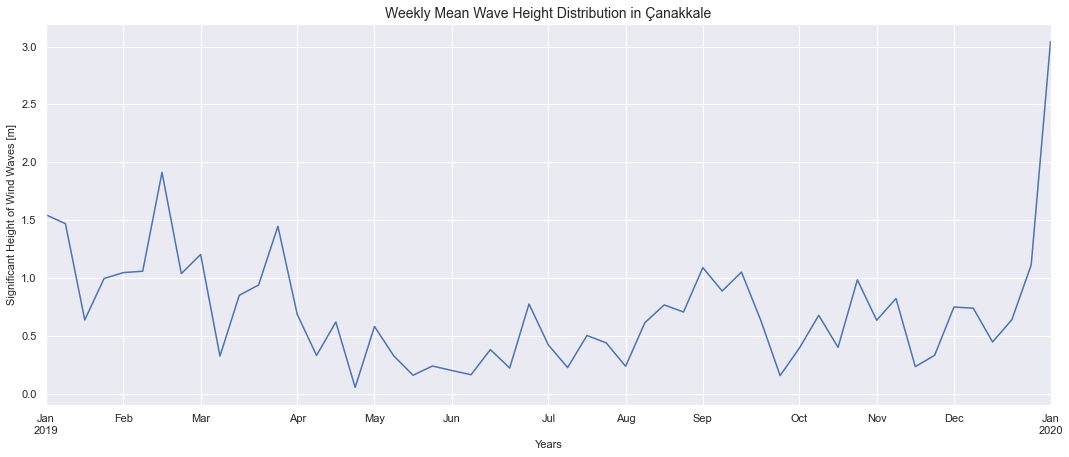

In [17]:
cnk['2019-01':'2019-12'].shww.resample('W').mean().plot(figsize=(18,7))
plt.title('Weekly Mean Wave Height Distribution in Çanakkale', fontsize=14)
plt.ylabel('Significant Height of Wind Waves [m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

### 2.4. Viz. for mean period of wind waves 

Text(0.5, 0, 'Years')

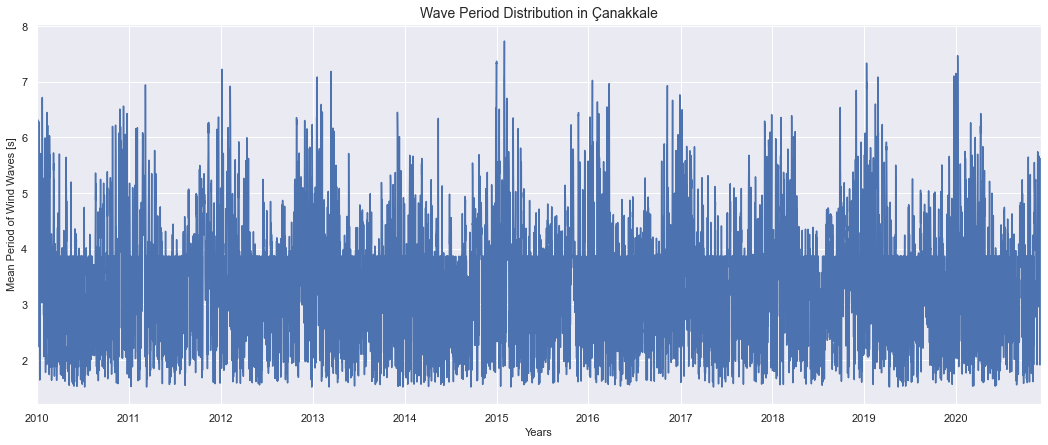

In [18]:
cnk.mpww.plot(figsize=(18,7))
plt.title('Wave Period Distribution in Çanakkale', fontsize=14)
plt.ylabel('Mean Period of Wind Waves [s]', fontsize=11)
plt.xlabel('Years', fontsize=11)

Text(0.5, 0, 'Years')

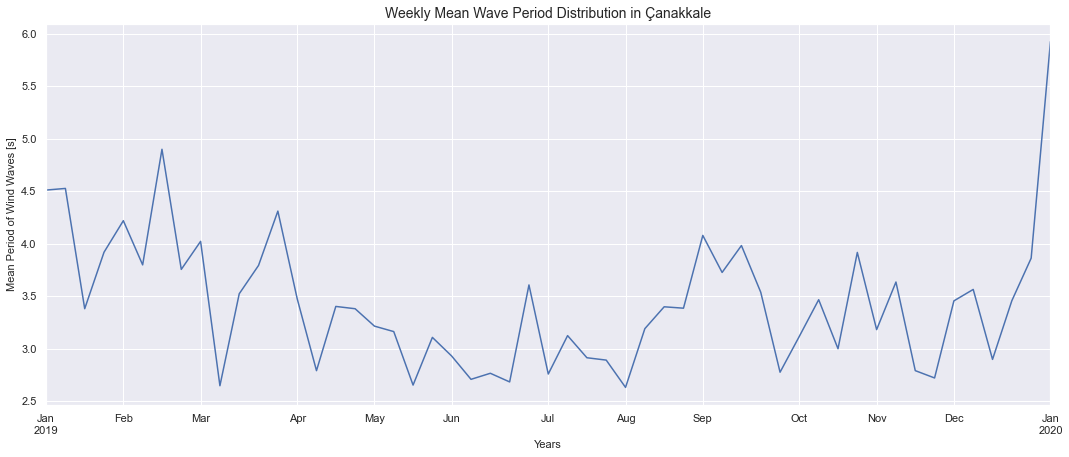

In [19]:
cnk['2019-01':'2019-12'].mpww.resample('W').mean().plot(figsize=(18,7))
plt.title('Weekly Mean Wave Period Distribution in Çanakkale', fontsize=14)
plt.ylabel('Mean Period of Wind Waves [s]', fontsize=11)
plt.xlabel('Years', fontsize=11)

### 2.5. Daily and Weekly Data Comparison

In [20]:
df_week = cnk.resample("W").mean()
df_m = cnk.resample("D").mean()

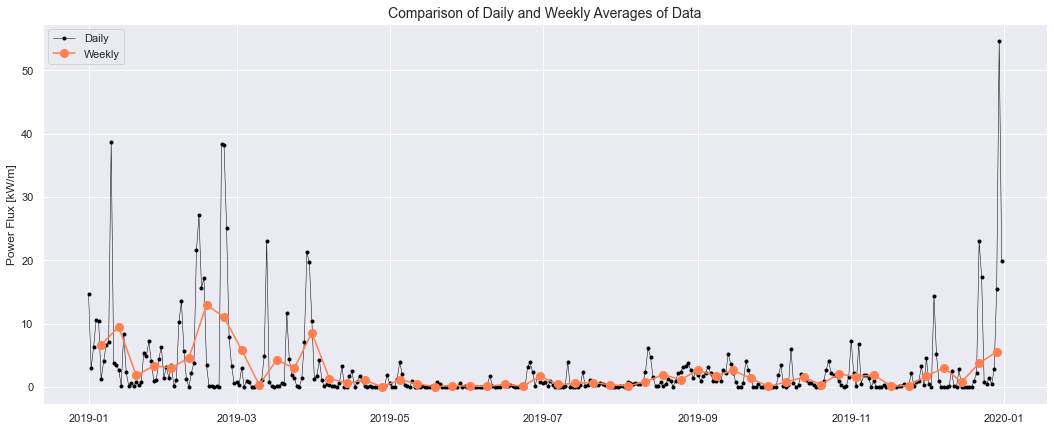

In [21]:
start, end = '2019-01', '2019-12'
fig, ax = plt.subplots(figsize=(18, 7))
ax.plot(df_m.loc[start:end, 'power'], marker='.', linestyle='-', linewidth = 0.5, label='Daily', color='black')
ax.plot(df_week.loc[start:end, 'power'], marker='o', markersize=8, linestyle='-', label='Weekly', color='coral', )
ax.set_ylabel("Power Flux [kW/m]")
ax.set_title('Comparison of Daily and Weekly Averages of Data', fontsize=14)
ax.legend()

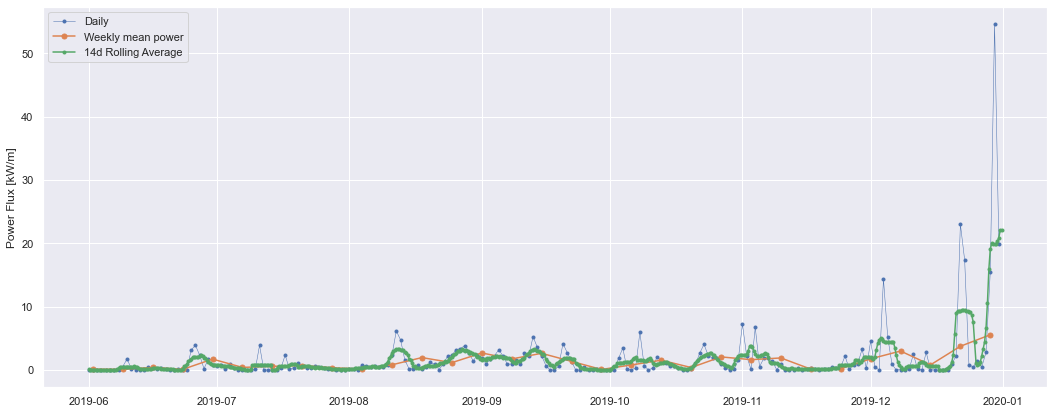

In [22]:
cnk_rolling = cnk.rolling(14, center=True).mean()
start, end = '2019-06', '2019-12'
fig, ax = plt.subplots(figsize=(18, 7))
ax.plot(df_m.loc[start:end, 'power'], marker='.', linestyle='-', 
        linewidth=0.5, label='Daily')
ax.plot(df_week.loc[start:end, 'power'], marker='o', markersize=5, 
        linestyle='-', label = 'Weekly mean power')
ax.plot(cnk_rolling.loc[start:end, 'power'], marker='.', linestyle='-', label='14d Rolling Average')
ax.set_ylabel('Power Flux [kW/m]')
ax.legend()

### 2.6. Expanding Window


#### Monthly

In [23]:
df_month = cnk.resample("M").mean()

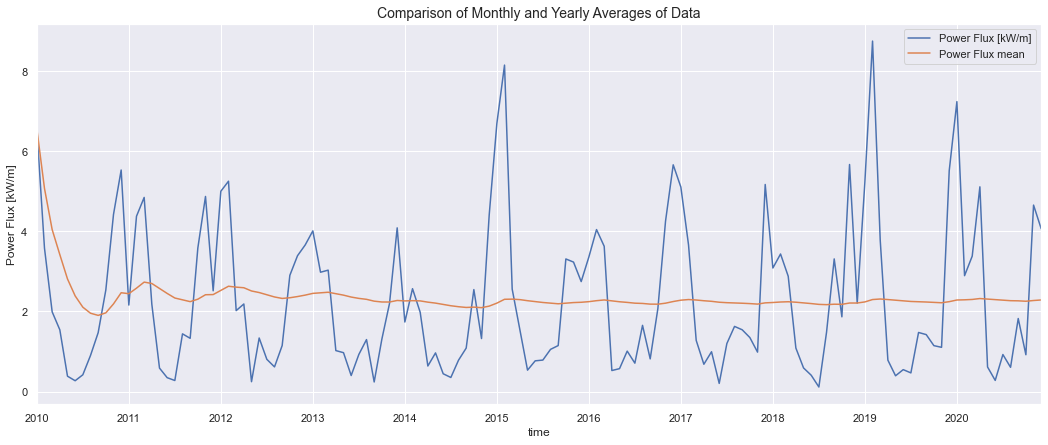

In [24]:
fig, ax = plt.subplots(figsize=(18, 7))
ax = df_month.power.plot(label='Power Flux [kW/m]')
ax = df_month.power.expanding().mean().plot(label='Power Flux mean')
ax.set_title('Comparison of Monthly and Yearly Averages of Data', fontsize=14)
ax.set_ylabel('Power Flux [kW/m]')
ax.legend()

#### Daily

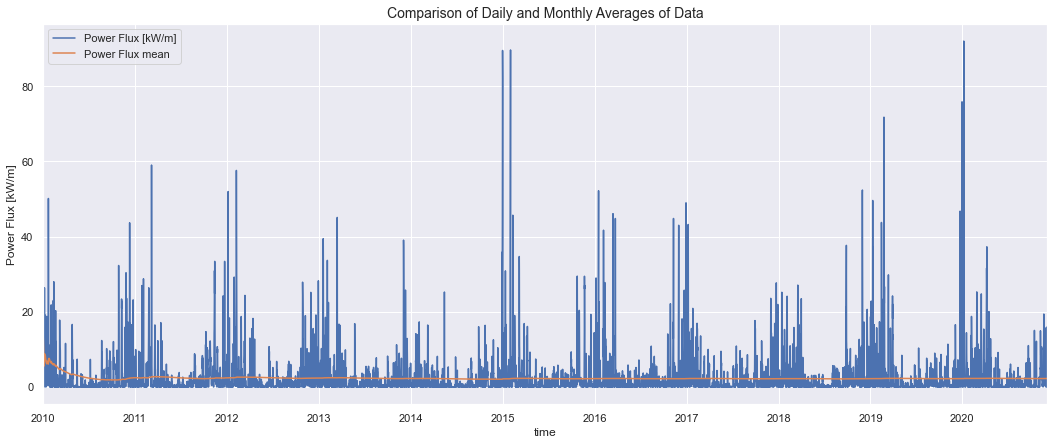

In [25]:
fig, ax = plt.subplots(figsize=(18, 7))
ax = cnk.power.plot(label='Power Flux [kW/m]')
ax = cnk.power.expanding().mean().plot(label='Power Flux mean')
ax.set_title('Comparison of Daily and Monthly Averages of Data', fontsize=14)
ax.set_ylabel('Power Flux [kW/m]', fontsize=12)
ax.legend()

### 2.7. Probability of the Exceedance

In [33]:
# work on this one

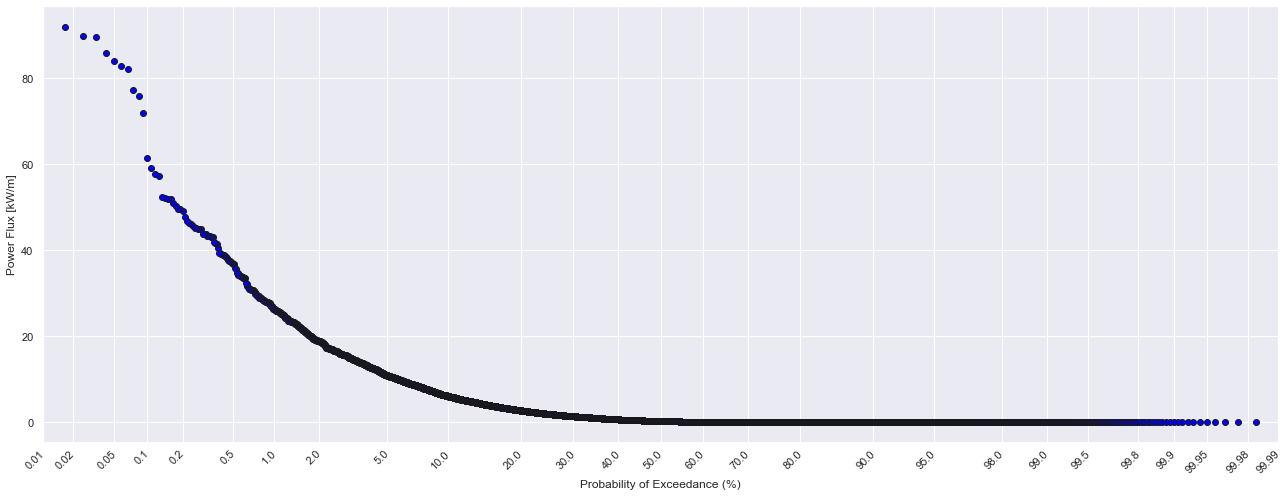

In [61]:
fig,ax = plt.subplots(figsize=(18, 7))

pp_x = sm.ProbPlot(cnk.power, fit=True)
pp_x.probplot(exceed=True, ax=ax, marker='.', color='k', markersize=12)

plt.xlabel('Probability of Exceedance (%)', fontsize=12)
plt.ylabel('Power Flux [kW/m]', fontsize=12)
plt.tight_layout()
plt.show()

## 3. Analysis for a single point - Çanakkale/Babakale 

In [29]:
babakale = era.loc[((era['latitude'] >= 39.50) & (era['latitude'] <= 39.60) &  (era['longitude'] >= 26.00) & 
                   (era['longitude'] <= 26.10) )]

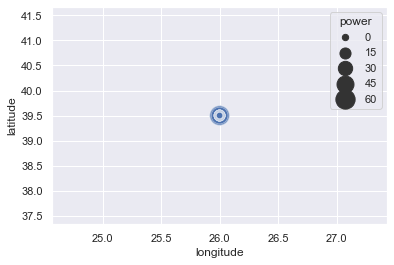

In [30]:
ax = sns.scatterplot(x='longitude', y='latitude',
                     size='power',
                     sizes=(40, 400), alpha=.7,
                     data=babakale)

### 3.1. Wave Height-Period Distribution in Babakale 

Text(0, 0.5, 'Significant height of wind waves [m]')

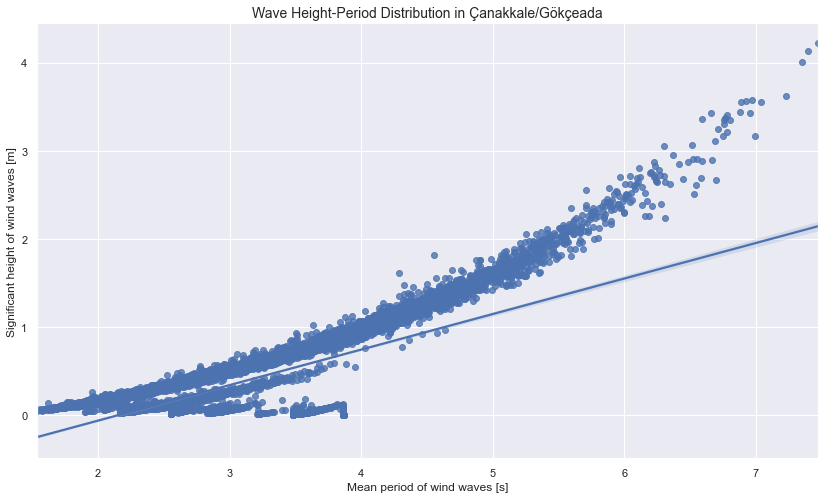

In [31]:
plt.figure(figsize=(14, 8))
g = sns.regplot(
    data=babakale,
    x='mpww', y='shww')
g.set_title('Wave Height-Period Distribution in Çanakkale/Gökçeada', fontsize=14)
g.set_xlabel('Mean period of wind waves [s]', fontsize=12)
g.set_ylabel('Significant height of wind waves [m]', fontsize=12)

### 3.2. Power Flux Graphs

#### 3.2.1. Heatmap Demonstration

In [51]:
babakale1 = era_t.loc[((era_t['latitude'] >= 39.50) & (era_t['latitude'] <= 39.60) &  (era_t['longitude'] >= 26.00) & 
                   (era_t['longitude'] <= 26.10) )]

babakale1['month'] = pd.DatetimeIndex(babakale1.index).month
babakale1['year'] = pd.DatetimeIndex(babakale1.index).year

In [52]:
import calendar
all_month_year_df = pd.pivot_table(babakale1, values="power",
                                   index='month',
                                   columns='year',
                                   fill_value=0,
                                   margins=True)
named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_df.index)]] # name months
all_month_year_df = all_month_year_df.set_index(named_index)

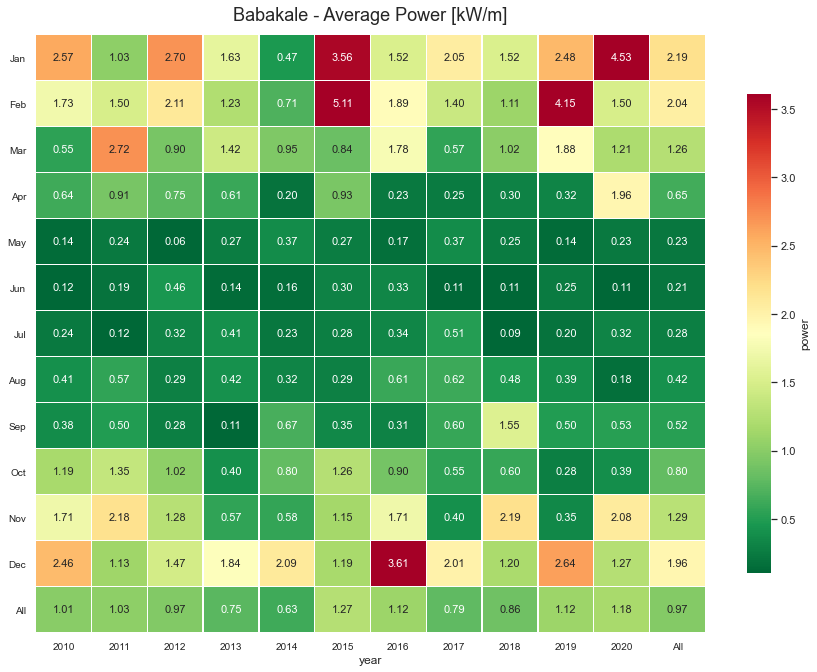

In [58]:
plt.figure(figsize=(15, 11))
ax = sns.heatmap(all_month_year_df, cmap='RdYlGn_r', robust=True, fmt='.2f', 
                 annot=True, linewidths=.5, annot_kws={'size':11}, 
                 cbar_kws={'shrink':.8, 'label':'power'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Babakale - Average Power [kW/m]', fontdict={'fontsize':18},    pad=14);

#### 3.2.2. Power Distribution Graphs 

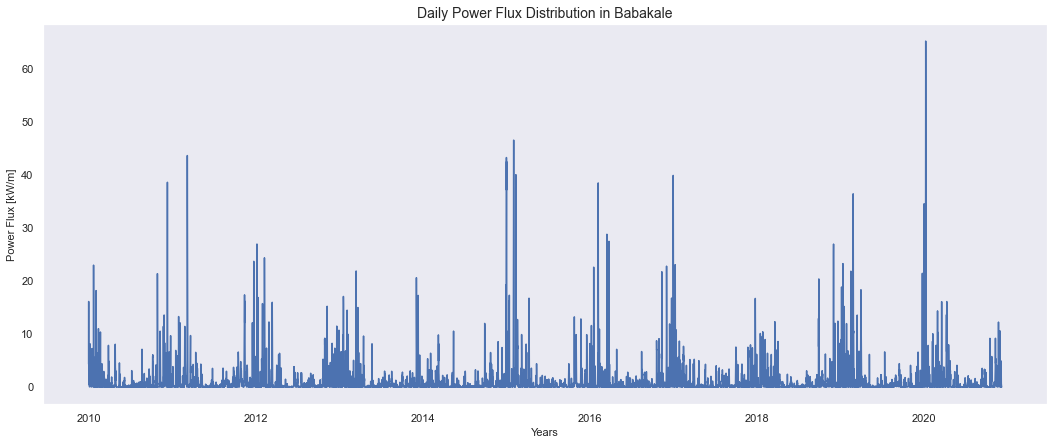

In [34]:
plt.figure(figsize=(18, 7))
plt.plot(babakale.power)

plt.title('Daily Power Flux Distribution in Babakale', fontsize=14)
plt.ylabel('Power Flux [kW/m]', fontsize=11)
plt.xlabel('Years', fontsize=11)
plt.grid(False)
plt.show()

Text(0.5, 0, 'Years')

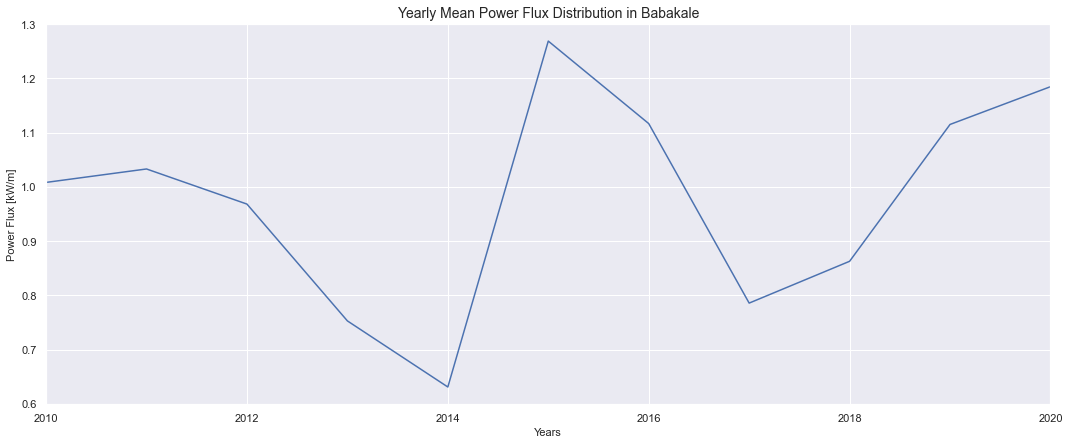

In [35]:
babakale.power.resample('Y').mean().plot(figsize=(18,7))
plt.title('Yearly Mean Power Flux Distribution in Babakale', fontsize=14)
plt.ylabel('Power Flux [kW/m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

Text(0.5, 0, 'Years')

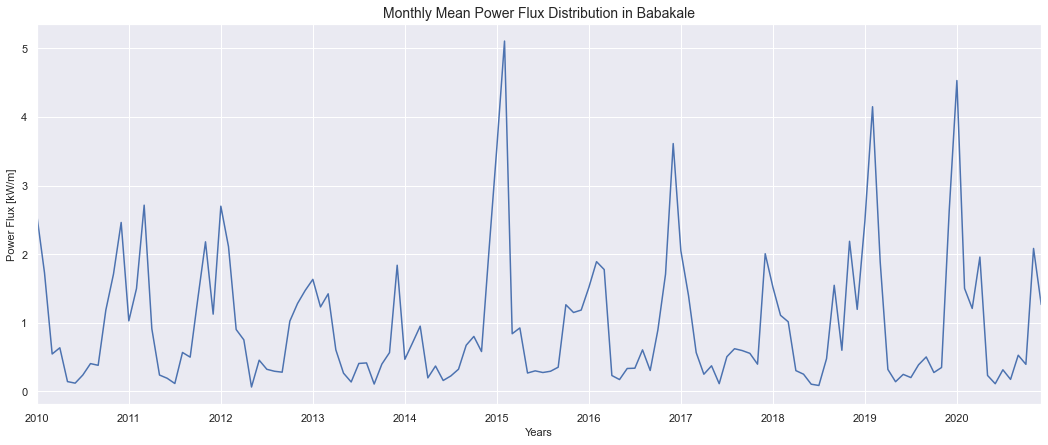

In [36]:
babakale.power.resample('M').mean().plot(figsize=(18,7))
plt.title('Monthly Mean Power Flux Distribution in Babakale', fontsize=14)
plt.ylabel('Power Flux [kW/m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

Text(0.5, 0, 'Years')

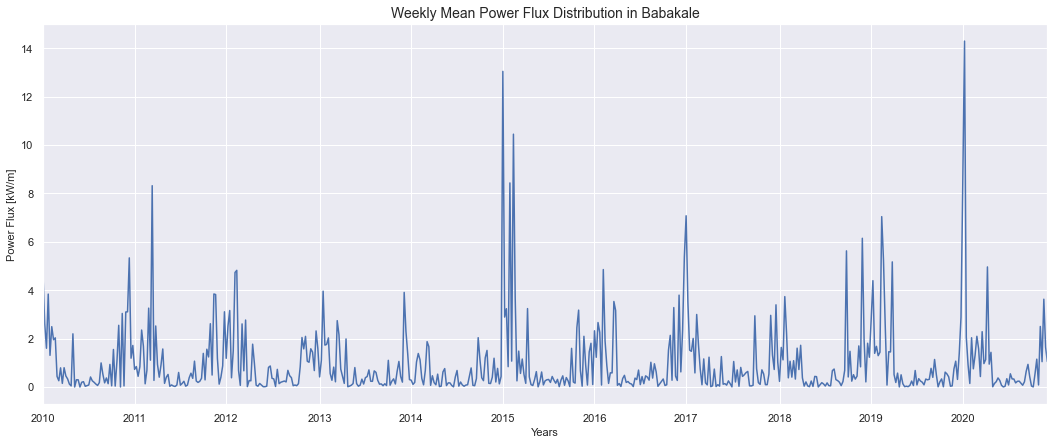

In [37]:
babakale.power.resample('W').mean().plot(figsize=(18,7))
plt.title('Weekly Mean Power Flux Distribution in Babakale', fontsize=14)
plt.ylabel('Power Flux [kW/m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

### 3.3. Viz. for significant height of wind waves

Text(0.5, 0, 'Years')

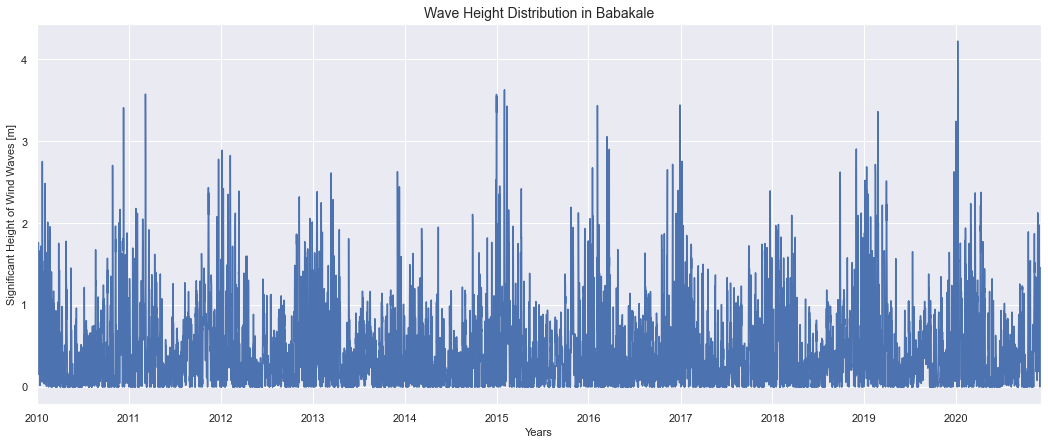

In [38]:
babakale.shww.plot(figsize=(18,7))
plt.title('Wave Height Distribution in Babakale', fontsize=14)
plt.ylabel('Significant Height of Wind Waves [m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

Text(0.5, 0, 'Years')

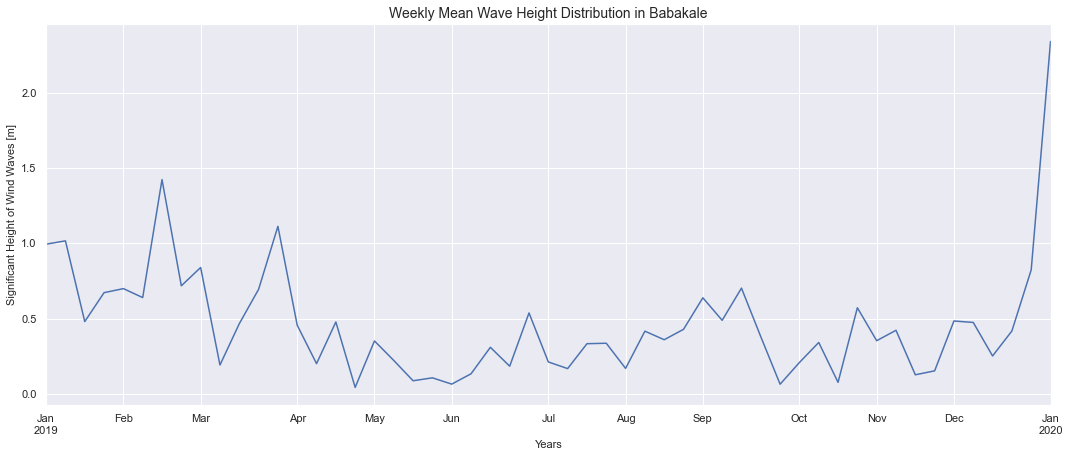

In [39]:
babakale['2019-01':'2019-12'].shww.resample('W').mean().plot(figsize=(18,7))
plt.title('Weekly Mean Wave Height Distribution in Babakale', fontsize=14)
plt.ylabel('Significant Height of Wind Waves [m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

### 3.4. Viz. for mean period of wind waves 

Text(0.5, 0, 'Years')

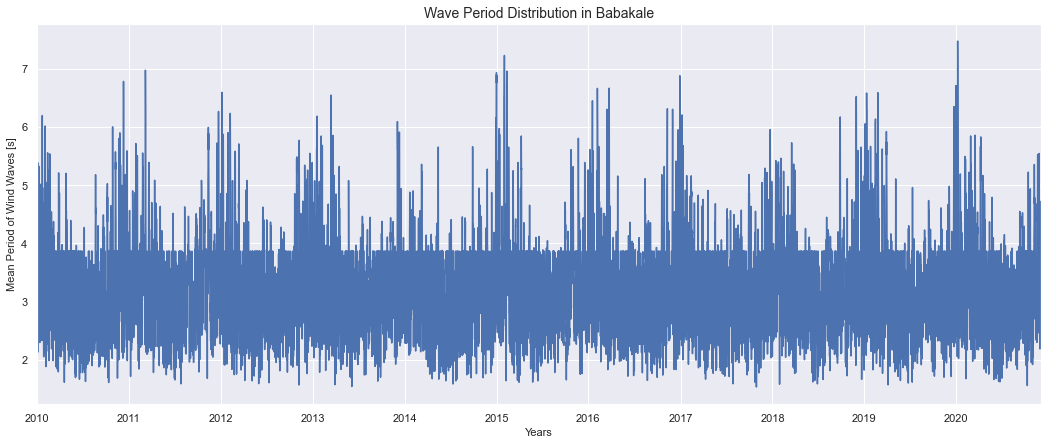

In [40]:
babakale.mpww.plot(figsize=(18,7))
plt.title('Wave Period Distribution in Babakale', fontsize=14)
plt.ylabel('Mean Period of Wind Waves [s]', fontsize=11)
plt.xlabel('Years', fontsize=11)

Text(0.5, 0, 'Years')

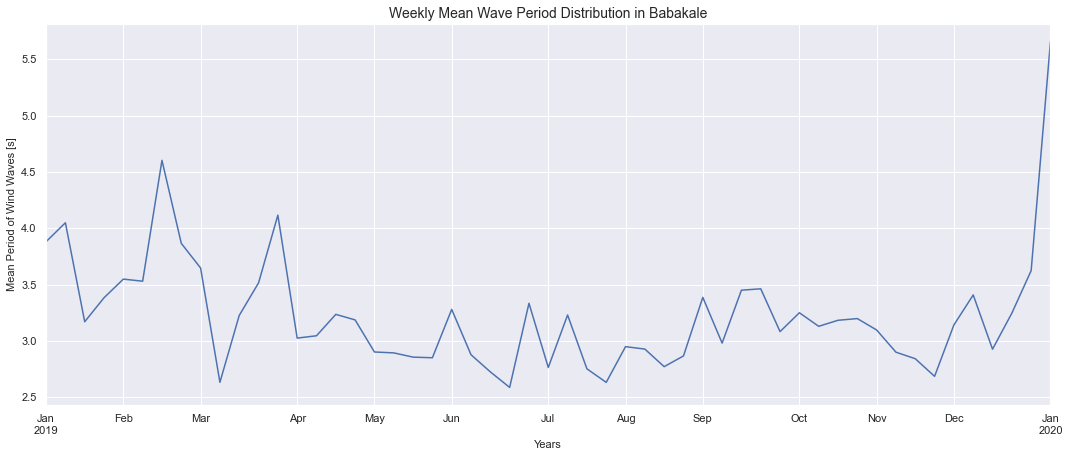

In [41]:
babakale['2019-01':'2019-12'].mpww.resample('W').mean().plot(figsize=(18,7))
plt.title('Weekly Mean Wave Period Distribution in Babakale', fontsize=14)
plt.ylabel('Mean Period of Wind Waves [s]', fontsize=11)
plt.xlabel('Years', fontsize=11)

### 3.5. Daily and Weekly Data Comparison

In [42]:
df_week = babakale.resample("W").mean()
df_m = babakale.resample("D").mean()

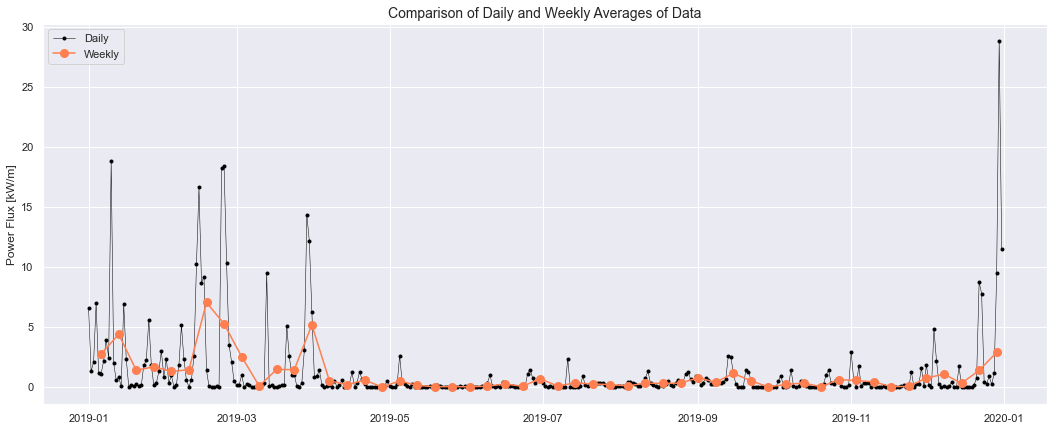

In [43]:
start, end = '2019-01', '2019-12'
fig, ax = plt.subplots(figsize=(18, 7))
ax.plot(df_m.loc[start:end, 'power'], marker='.', linestyle='-', linewidth = 0.5, label='Daily', color='black')
ax.plot(df_week.loc[start:end, 'power'], marker='o', markersize=8, linestyle='-', label='Weekly', color='coral', )
ax.set_ylabel("Power Flux [kW/m]")
ax.set_title('Comparison of Daily and Weekly Averages of Data', fontsize=14)
ax.legend()

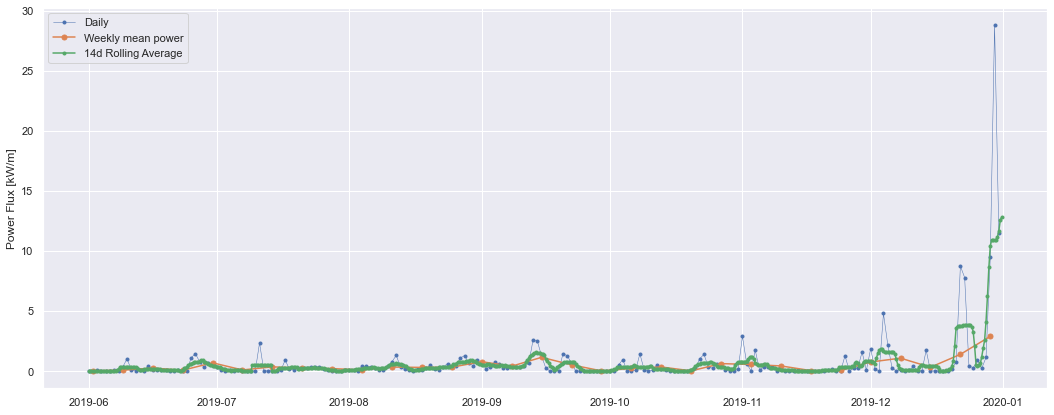

In [44]:
cnk_rolling = babakale.rolling(14, center=True).mean()
start, end = '2019-06', '2019-12'
fig, ax = plt.subplots(figsize=(18, 7))
ax.plot(df_m.loc[start:end, 'power'], marker='.', linestyle='-', 
        linewidth=0.5, label='Daily')
ax.plot(df_week.loc[start:end, 'power'], marker='o', markersize=5, 
        linestyle='-', label = 'Weekly mean power')
ax.plot(cnk_rolling.loc[start:end, 'power'], marker='.', linestyle='-', label='14d Rolling Average')
ax.set_ylabel('Power Flux [kW/m]')
ax.legend()

### 3.6. Expanding Window

#### Monthly 

In [45]:
df_month = babakale.resample("M").mean()

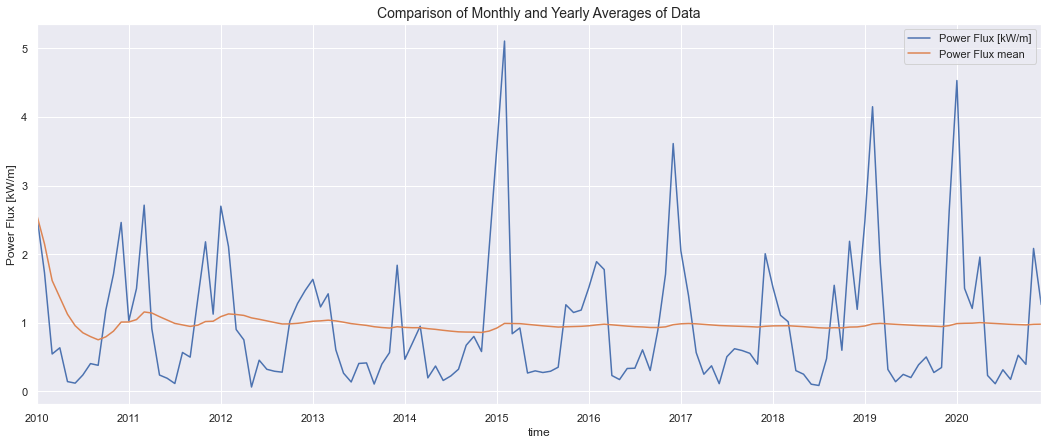

In [46]:
fig, ax = plt.subplots(figsize=(18, 7))
ax = df_month.power.plot(label='Power Flux [kW/m]')
ax = df_month.power.expanding().mean().plot(label='Power Flux mean')
ax.set_title('Comparison of Monthly and Yearly Averages of Data', fontsize=14)
ax.set_ylabel('Power Flux [kW/m]')
ax.legend()

#### Daily 

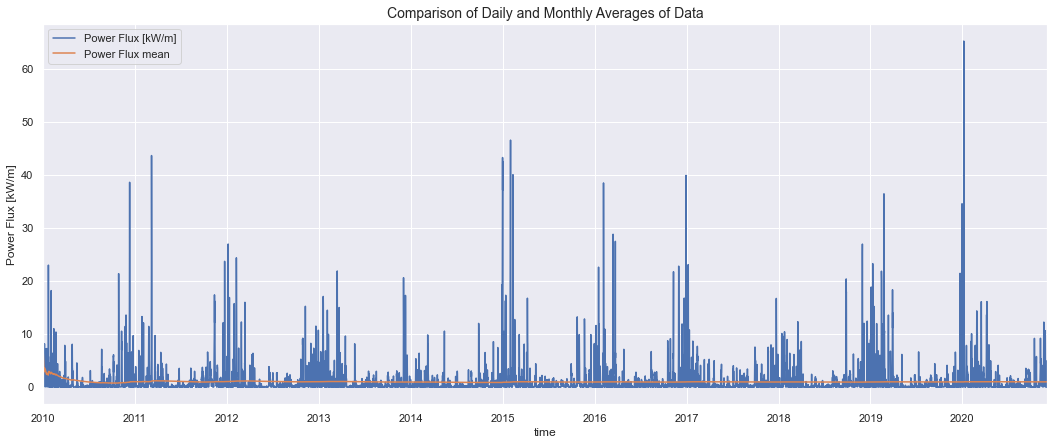

In [47]:
fig, ax = plt.subplots(figsize=(18, 7))
ax = babakale.power.plot(label='Power Flux [kW/m]')
ax = babakale.power.expanding().mean().plot(label='Power Flux mean')
ax.set_title('Comparison of Daily and Monthly Averages of Data', fontsize=14)
ax.set_ylabel('Power Flux [kW/m]', fontsize=12)
ax.legend()

### 3.7. Probability of the Exceedance

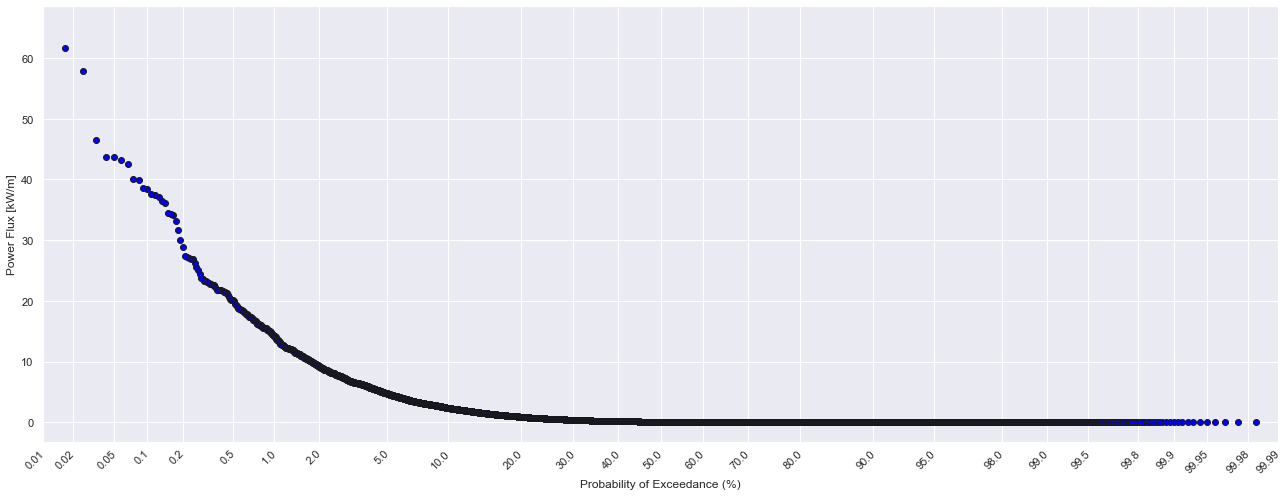

In [48]:
fig,ax = plt.subplots(figsize=(18, 7))

pp_x = sm.ProbPlot(babakale.power, fit=True)
pp_x.probplot(exceed=True, ax=ax, marker='.', color='k', markersize=12)

plt.xlabel('Probability of Exceedance (%)', fontsize=12)
plt.ylabel('Power Flux [kW/m]', fontsize=12)
plt.tight_layout()
plt.show()

## 4. Analysis for a single point - Antalya/Alanya

In [16]:
antlya = era.loc[((era['latitude'] >= 36.50) & (era['latitude'] <= 36.60) &  (era['longitude'] >= 32.00) & 
                   (era['longitude'] <= 32.10) )]

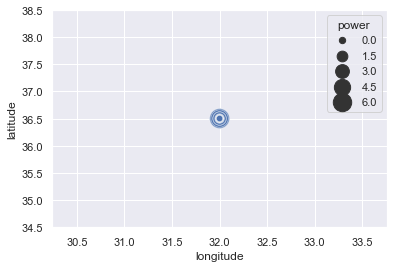

In [13]:
ax = sns.scatterplot(x='longitude', y='latitude',
                     size='power',
                     sizes=(40, 400), alpha=.7,
                     data=antlya)

### 4.2. Wave Height-Period Distribution in Alanya Grid 36.50-32.00

Text(0, 0.5, 'Significant height of wind waves [m]')

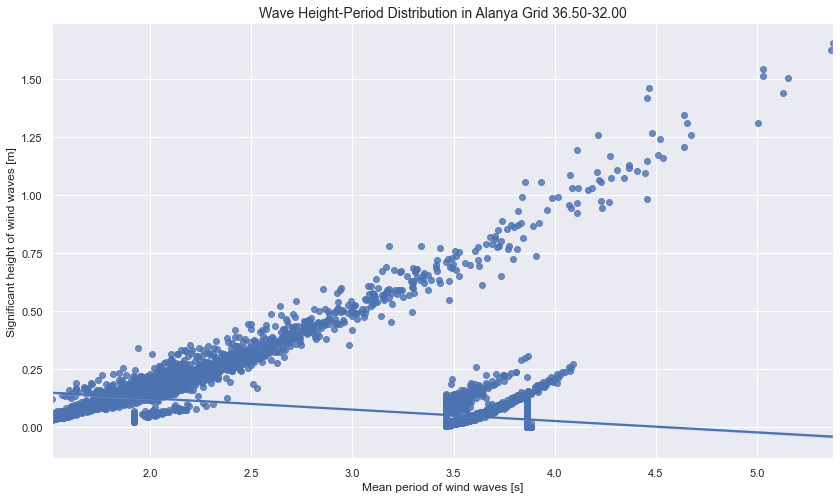

In [14]:
plt.figure(figsize=(14, 8))
g = sns.regplot(
    data=antlya,
    x='mpww', y='shww')
g.set_title('Wave Height-Period Distribution in Alanya Grid 36.50-32.00', fontsize=14)
g.set_xlabel('Mean period of wind waves [s]', fontsize=12)
g.set_ylabel('Significant height of wind waves [m]', fontsize=12)

### 4.2. Power Flux Graphs 

#### 4.2.1. Heatmap Demonstration

In [19]:
antlya1 = era_t.loc[((era_t['latitude'] >= 36.50) & (era_t['latitude'] <= 36.60) &  (era_t['longitude'] >= 32.00) & 
                   (era_t['longitude'] <= 32.10) )]

antlya1['month'] = pd.DatetimeIndex(antlya1.index).month
antlya1['year'] = pd.DatetimeIndex(antlya1.index).year

In [20]:
import calendar
all_month_year_df = pd.pivot_table(antlya1, values="power",
                                   index='month',
                                   columns='year',
                                   fill_value=0,
                                   margins=True)
named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_df.index)]] # name months
all_month_year_df = all_month_year_df.set_index(named_index)

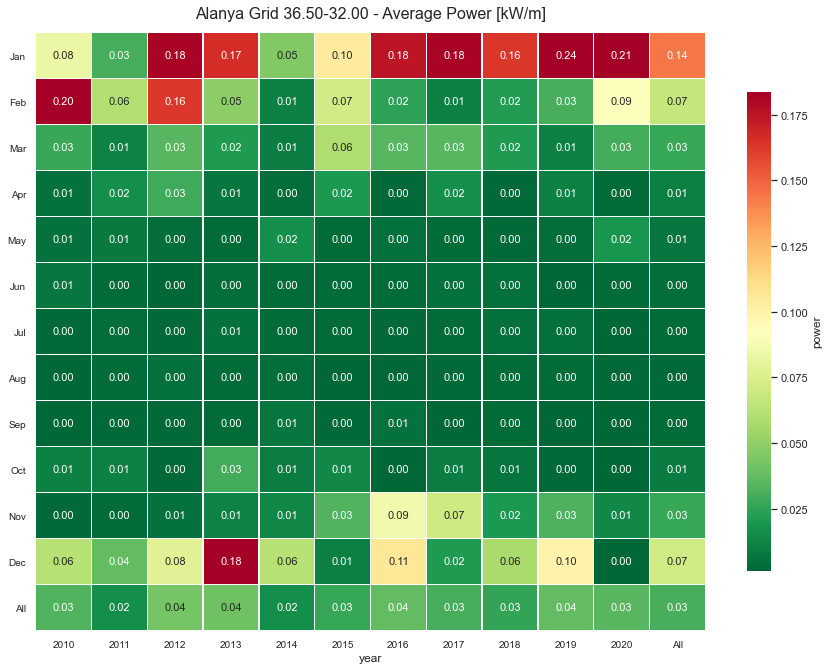

In [38]:
plt.figure(figsize=(15, 11))
ax = sns.heatmap(all_month_year_df, cmap='RdYlGn_r', robust=True, fmt='.2f', 
                 annot=True, linewidths=.5, annot_kws={'size':11}, 
                 cbar_kws={'shrink':.8, 'label':'power'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Alanya Grid 36.50-32.00 - Average Power [kW/m]', fontdict={'fontsize':16},    pad=14);

####  4.2.2. Power Distribution Graphs

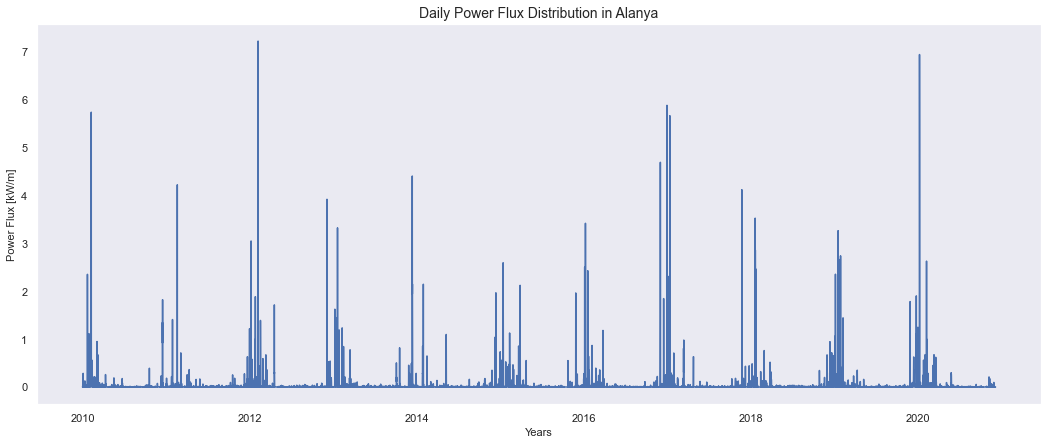

In [23]:
plt.figure(figsize=(18, 7))
plt.plot(antlya.power)

plt.title('Daily Power Flux Distribution in Alanya Grid 36.50-32.00', fontsize=14)
plt.ylabel('Power Flux [kW/m]', fontsize=11)
plt.xlabel('Years', fontsize=11)
plt.grid(False)
plt.show()

Text(0.5, 0, 'Years')

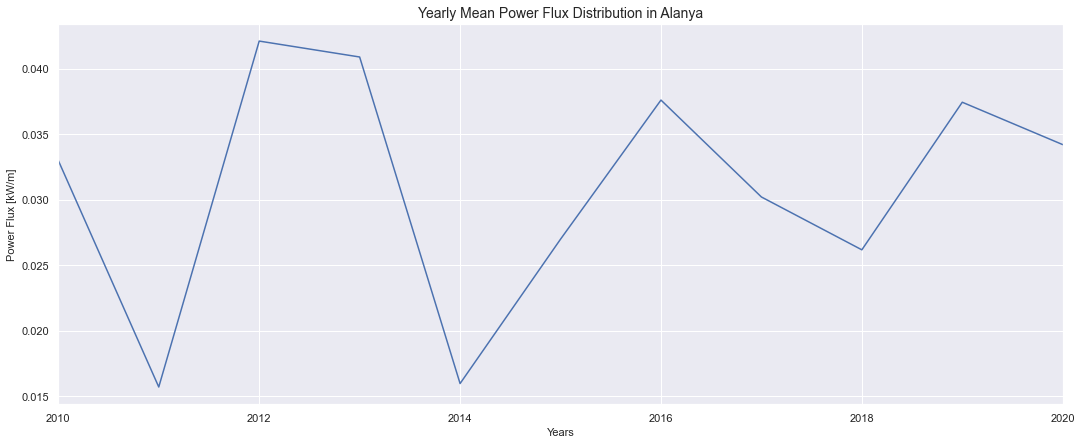

In [24]:
antlya.power.resample('Y').mean().plot(figsize=(18,7))
plt.title('Yearly Mean Power Flux Distribution in Alanya Grid 36.50-32.00', fontsize=14)
plt.ylabel('Power Flux [kW/m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

Text(0.5, 0, 'Years')

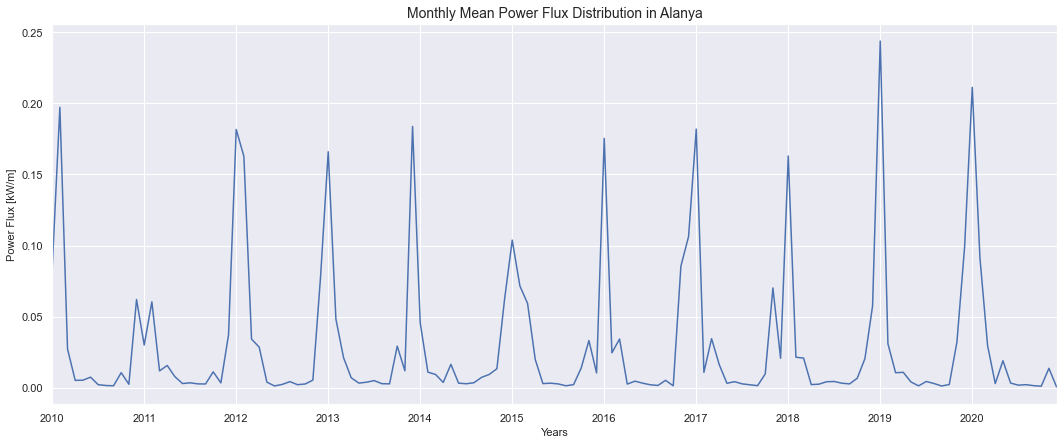

In [25]:
antlya.power.resample('M').mean().plot(figsize=(18,7))
plt.title('Monthly Mean Power Flux Distribution in Alanya Grid 36.50-32.00', fontsize=14)
plt.ylabel('Power Flux [kW/m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

Text(0.5, 0, 'Years')

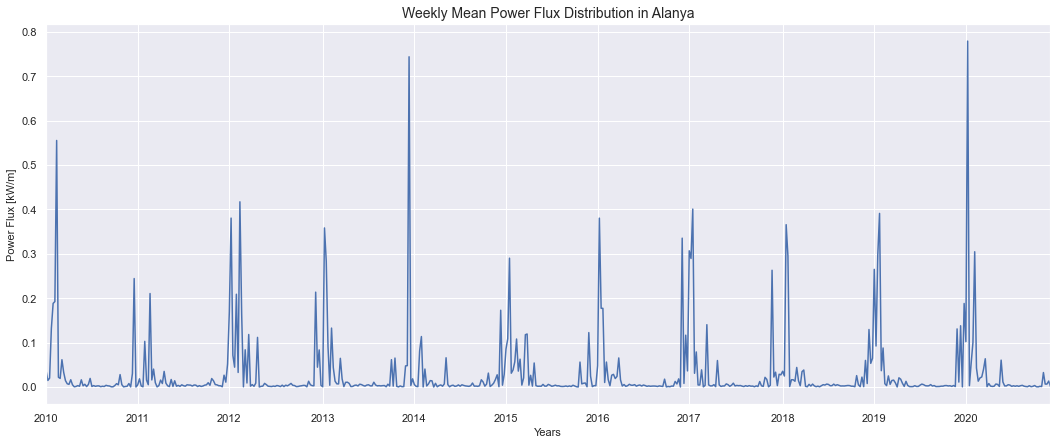

In [26]:
antlya.power.resample('W').mean().plot(figsize=(18,7))
plt.title('Weekly Mean Power Flux Distribution in Alanya Grid 36.50-32.00', fontsize=14)
plt.ylabel('Power Flux [kW/m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

### 4.3. Viz. for significant height of wind waves 

Text(0.5, 0, 'Years')

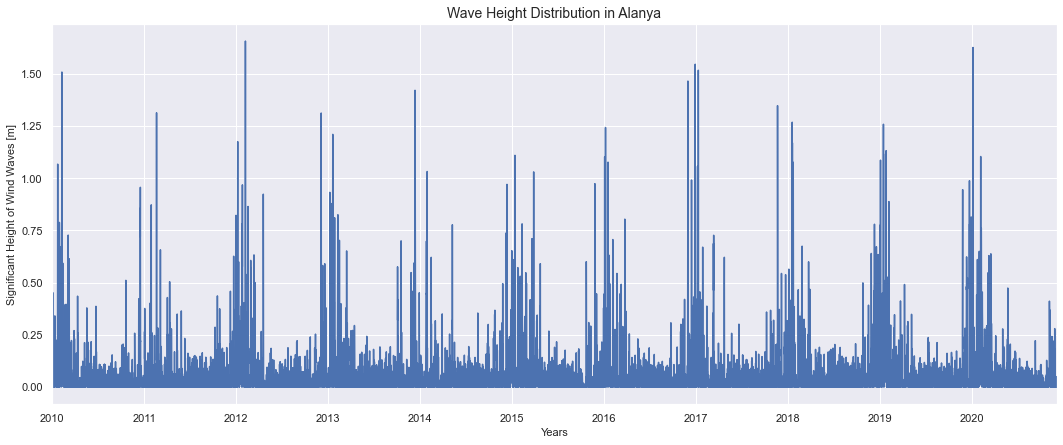

In [27]:
antlya.shww.plot(figsize=(18,7))
plt.title('Wave Height Distribution in Alanya Grid 36.50-32.00', fontsize=14)
plt.ylabel('Significant Height of Wind Waves [m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

Text(0.5, 0, 'Years')

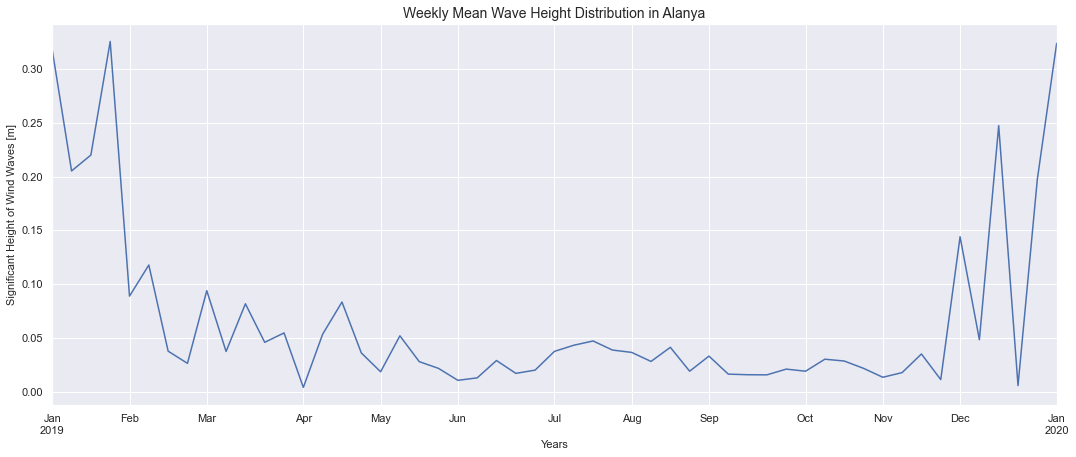

In [28]:
antlya['2019-01':'2019-12'].shww.resample('W').mean().plot(figsize=(18,7))
plt.title('Weekly Mean Wave Height Distribution in Alanya Grid 36.50-32.00', fontsize=14)
plt.ylabel('Significant Height of Wind Waves [m]', fontsize=11)
plt.xlabel('Years', fontsize=11)

### 4.4. Viz. for mean period of wind waves 

Text(0.5, 0, 'Years')

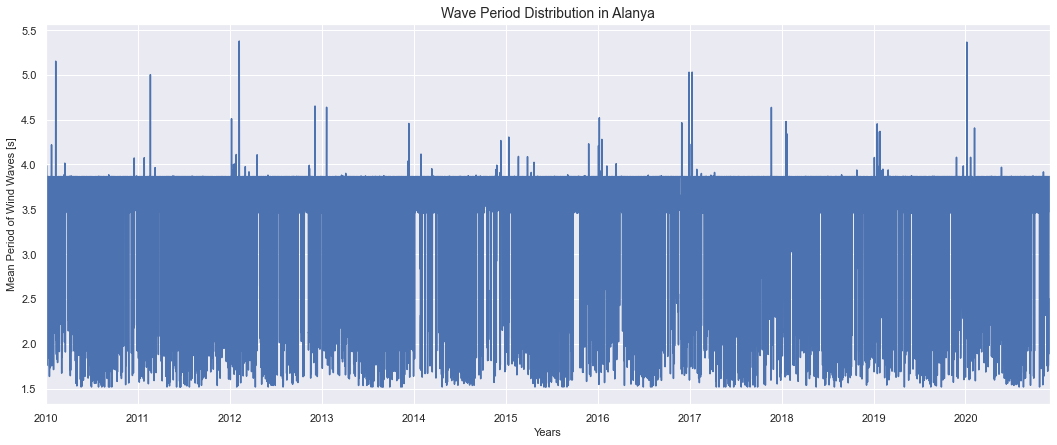

In [29]:
antlya.mpww.plot(figsize=(18,7))
plt.title('Wave Period Distribution in Alanya Grid 36.50-32.00', fontsize=14)
plt.ylabel('Mean Period of Wind Waves [s]', fontsize=11)
plt.xlabel('Years', fontsize=11)

Text(0.5, 0, 'Years')

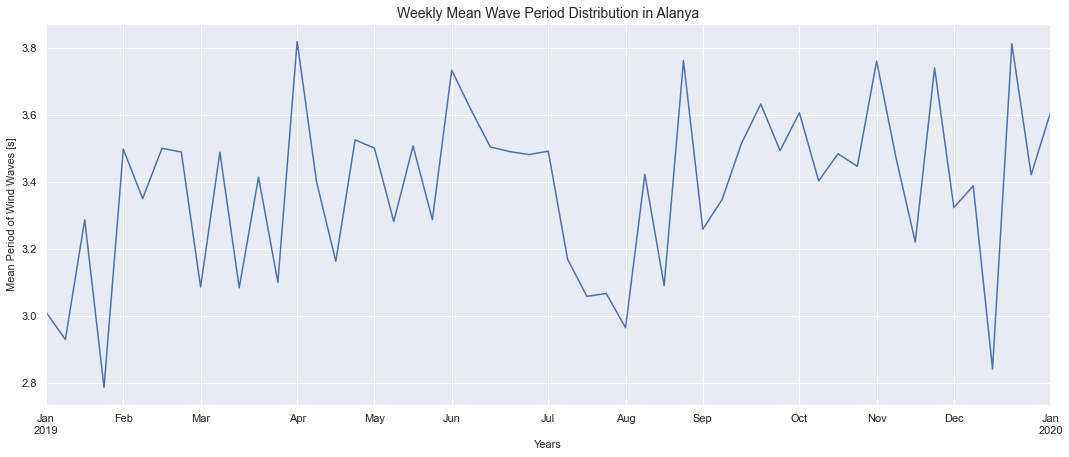

In [30]:
antlya['2019-01':'2019-12'].mpww.resample('W').mean().plot(figsize=(18,7))
plt.title('Weekly Mean Wave Period Distribution in Alanya Grid 36.50-32.00', fontsize=14)
plt.ylabel('Mean Period of Wind Waves [s]', fontsize=11)
plt.xlabel('Years', fontsize=11)

### 4.5. Daily and Weekly Data Comparison 

In [31]:
df_week = antlya.resample("W").mean()
df_m = antlya.resample("D").mean()

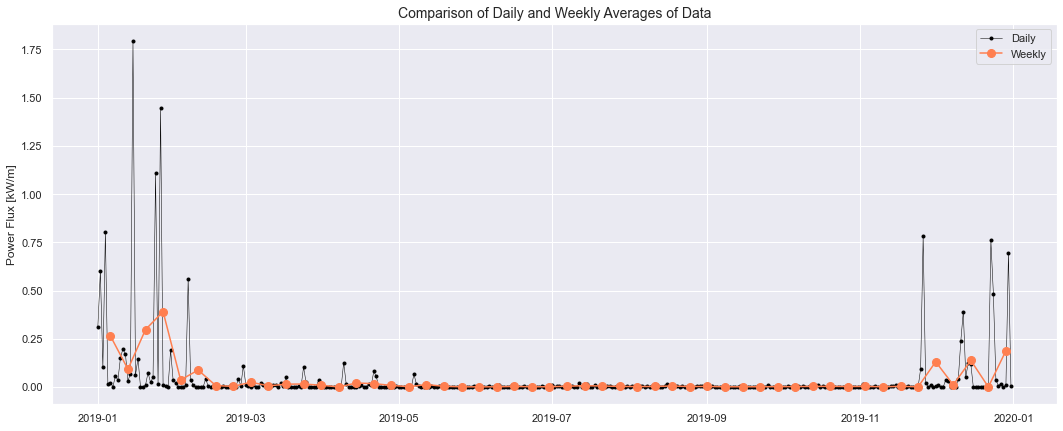

In [32]:
start, end = '2019-01', '2019-12'
fig, ax = plt.subplots(figsize=(18, 7))
ax.plot(df_m.loc[start:end, 'power'], marker='.', linestyle='-', linewidth = 0.5, label='Daily', color='black')
ax.plot(df_week.loc[start:end, 'power'], marker='o', markersize=8, linestyle='-', label='Weekly', color='coral', )
ax.set_ylabel("Power Flux [kW/m]")
ax.set_title('Comparison of Daily and Weekly Averages of Data', fontsize=14)
ax.legend()

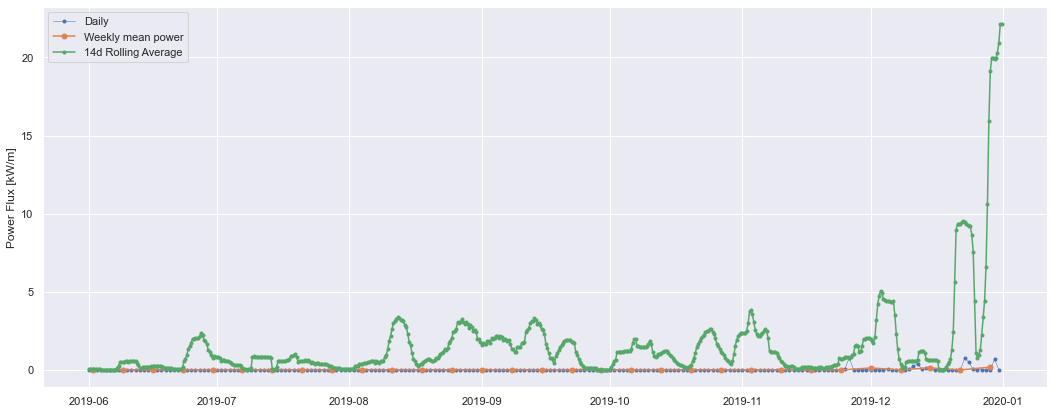

In [33]:
cnk_rolling = cnk.rolling(14, center=True).mean()
start, end = '2019-06', '2019-12'
fig, ax = plt.subplots(figsize=(18, 7))
ax.plot(df_m.loc[start:end, 'power'], marker='.', linestyle='-', 
        linewidth=0.5, label='Daily')
ax.plot(df_week.loc[start:end, 'power'], marker='o', markersize=5, 
        linestyle='-', label = 'Weekly mean power')
ax.plot(cnk_rolling.loc[start:end, 'power'], marker='.', linestyle='-', label='14d Rolling Average')
ax.set_ylabel('Power Flux [kW/m]')
ax.legend()

### 4.6. Expanding Window

#### Monthly

In [34]:
df_month = antlya.resample("M").mean()

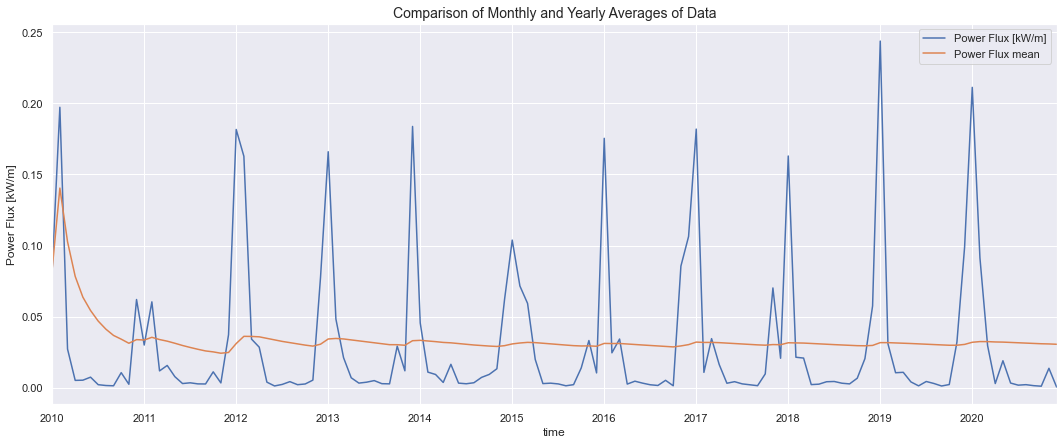

In [35]:
fig, ax = plt.subplots(figsize=(18, 7))
ax = df_month.power.plot(label='Power Flux [kW/m]')
ax = df_month.power.expanding().mean().plot(label='Power Flux mean')
ax.set_title('Comparison of Monthly and Yearly Averages of Data', fontsize=14)
ax.set_ylabel('Power Flux [kW/m]')
ax.legend()

#### Daily

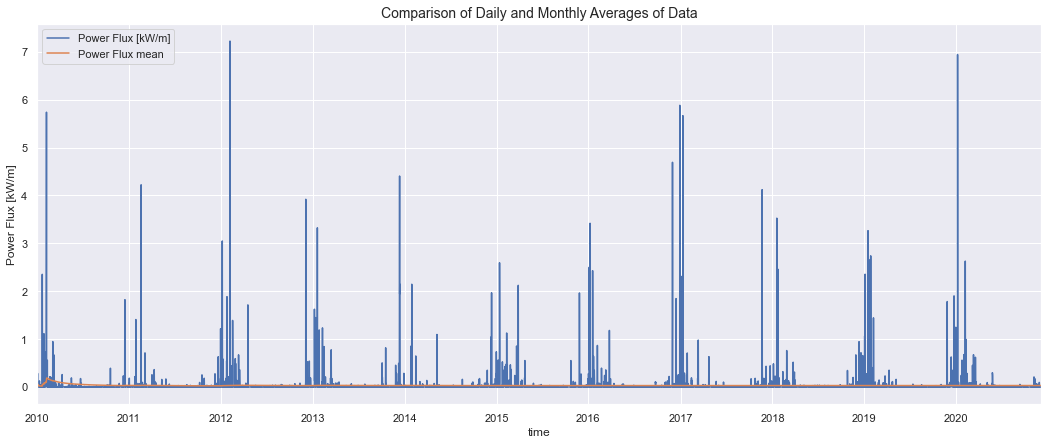

In [36]:
fig, ax = plt.subplots(figsize=(18, 7))
ax = antlya.power.plot(label='Power Flux [kW/m]')
ax = antlya.power.expanding().mean().plot(label='Power Flux mean')
ax.set_title('Comparison of Daily and Monthly Averages of Data', fontsize=14)
ax.set_ylabel('Power Flux [kW/m]', fontsize=12)
ax.legend()

### 4.7.  Probability of the Exceedance

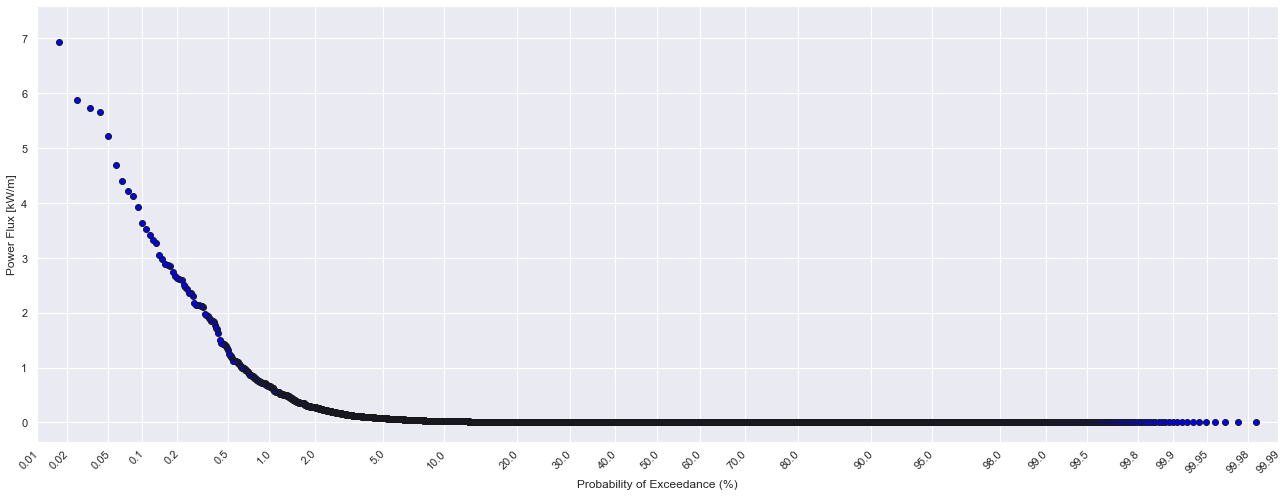

In [37]:
fig,ax = plt.subplots(figsize=(18, 7))

pp_x = sm.ProbPlot(antlya.power, fit=True)
pp_x.probplot(exceed=True, ax=ax, marker='.', color='k', markersize=12)

plt.xlabel('Probability of Exceedance (%)', fontsize=12)
plt.ylabel('Power Flux [kW/m]', fontsize=12)
plt.tight_layout()
plt.show()